In [88]:
import pandas as pd
import numpy as np

import dask.dataframe as dd
import dask.distributed

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import time
import spacy

In [2]:
cd

/Users/livanshu


In [3]:
start = time.time()

usecols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'FILEDATE',
       'FDATEUSE', 'JURIS', 'NOS', 'RESIDENC',
       'JURY', 'DEMANDED', 'COUNTY', 'PLT', 'DEF', 'TERMDATE', 'TDATEUSE',
       'PROCPROG', 'DISP', 'NOJ', 'AMTREC', 'JUDGMENT',
       'PROSE', 'STATUSCD', 'TAPEYEAR']

dtype={'ARBIT': 'object',
       'DISTRICT': 'object',
       'TRMARB': 'object',
       'OFFICE': 'object',
       'JURY': 'object',
       'MDLDOCK': 'object',
       'PRETRIAL': 'object',
       'SECTION': 'object',
       'SUBSECT': 'object',
       'TRANSDAT': 'object',
       'TRIALEND': 'object',
       'TRIBEGAN': 'object',
       'TRANSORG': 'object',
       'TRANSOFF': 'object',
       'IFP': 'object',
       'STATUSCD': 'object',
       'TITL': 'object'}

chunk = pd.read_csv("/Users/livanshu/Downloads/cv88on.txt",sep='\t',encoding='cp1252',chunksize=100000,low_memory=False)
df = pd.concat(chunk)

end = time.time()
print("Read csv with chunks: ",round(end-start,2),"sec")
df.info()
df.memory_usage(deep=True)

Read csv with chunks:  42.9 sec
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Data columns (total 46 columns):
 #   Column    Dtype  
---  ------    -----  
 0   CIRCUIT   int64  
 1   DISTRICT  object 
 2   OFFICE    object 
 3   DOCKET    int64  
 4   ORIGIN    int64  
 5   FILEDATE  object 
 6   FDATEUSE  object 
 7   JURIS     int64  
 8   NOS       int64  
 9   TITL      object 
 10  SECTION   object 
 11  SUBSECT   object 
 12  RESIDENC  int64  
 13  JURY      object 
 14  CLASSACT  int64  
 15  DEMANDED  int64  
 16  FILEJUDG  float64
 17  FILEMAG   float64
 18  COUNTY    int64  
 19  ARBIT     object 
 20  MDLDOCK   object 
 21  PLT       object 
 22  DEF       object 
 23  TRANSDAT  object 
 24  TRANSOFF  object 
 25  TRANSDOC  int64  
 26  TRANSORG  object 
 27  TERMDATE  object 
 28  TDATEUSE  object 
 29  TRCLACT   int64  
 30  TERMJUDG  float64
 31  TERMMAG   float64
 32  PROCPROG  int64  
 33  DISP      int64  
 34  NOJ       int64  
 35 

Index             128
CIRCUIT      75795552
DISTRICT    540592196
OFFICE      362339596
DOCKET       75795552
ORIGIN       75795552
FILEDATE    634787748
FDATEUSE    634787748
JURIS        75795552
NOS          75795552
TITL        346114812
SECTION     571394304
SUBSECT     558739552
RESIDENC     75795552
JURY        554649846
CLASSACT     75795552
DEMANDED     75795552
FILEJUDG     75795552
FILEMAG      75795552
COUNTY       75795552
ARBIT       554076523
MDLDOCK     412382188
PLT         641259071
DEF         712979574
TRANSDAT    306194938
TRANSOFF    364068895
TRANSDOC     75795552
TRANSORG    361770247
TERMDATE    634787538
TDATEUSE    612751993
TRCLACT      75795552
TERMJUDG     75795552
TERMMAG      75795552
PROCPROG     75795552
DISP         75795552
NOJ          75795552
AMTREC       75795552
JUDGMENT     75795552
DJOINED     417248748
PRETRIAL    329246568
TRIBEGAN    306646508
TRIALEND    308323253
TRMARB      542705368
PROSE        75795552
IFP         468449009
STATUSCD  

In [12]:
from dask.distributed import Client
client = Client(threads_per_worker=4)
client

/opt/homebrew/lib/python3.9/site-packages/distributed/node.py:181: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52673 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:52673/status,
Dashboard: http://127.0.0.1:52673/status,Workers: 2
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52674,Workers: 2
Dashboard: http://127.0.0.1:52673/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:52682,Total threads: 4
Dashboard: http://127.0.0.1:52683/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:52677,


In [17]:
import dask.dataframe as dd

start = time.time()
dtype={'ARBIT': 'object',
       'DISTRICT': 'object',
       'TRMARB': 'object',
       'OFFICE': 'object',
       'JURY': 'object',
       'MDLDOCK': 'object',
       'PRETRIAL': 'object',
       'SECTION': 'object',
       'SUBSECT': 'object',
       'TRANSDAT': 'object',
       'TRIALEND': 'object',
       'TRIBEGAN': 'object',
       'TRANSORG': 'object',
       'TRANSOFF': 'object',
       'IFP': 'object',
       'STATUSCD': 'object',
       'TITL': 'object'}

df_dask = dd.read_csv("/Users/livanshu/Downloads/cv88on.txt",sep='\t',encoding='cp1252',dtype=dtype, 
             blocksize=1000000)
end = time.time()
print("Read csv with dask: ",round(end-start,2),"sec")

#df_dask = df_dask.compute(scheduler="threads") # convert to pandas
#end = time.time()
#print("Convert dasf df to pandas: ",round(end-start,2),"sec")

df_dask.info()

Read csv with dask:  0.34 sec
<class 'dask.dataframe.core.DataFrame'>
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: object(24), float64(4), int64(18)

In [4]:
## Lower memory size by downcasting

def downcast_dtype(df):
  print("Dataframe Info before:\n")
  df.info(verbose=False)
  float_cols = df.select_dtypes('float').columns
  df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')

  int_cols = df.select_dtypes('integer').columns
  df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
  print("\n\nDataframe Info after:\n")
  df.info(verbose=False)

downcast_dtype(df)


Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: float64(4), int64(18), object(24)
memory usage: 3.2+ GB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474444 entries, 0 to 9474443
Columns: 46 entries, CIRCUIT to TAPEYEAR
dtypes: float32(4), int16(4), int32(3), int8(11), object(24)
memory usage: 2.1+ GB


In [7]:
def replace_values_from_dataset(df,values,newvalues):
  for value in values:
    for i in range(len(df.columns)):
      (df[df.columns[i]]).replace(values,newvalues,inplace=True)
    return df.head(10)

replace_values_from_dataset(df,('-8',-8),np.nan)

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
0,0,90,1,7101462,4.0,07/21/1971,07/01/1971,3.0,440,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
1,0,90,1,7300974,4.0,05/17/1973,02/01/1983,2.0,890,NaN,...,1.0,01/20/1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
2,0,90,1,7601326,4.0,01/31/1985,06/01/1985,2.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
3,0,90,1,7700081,3.0,09/19/1984,05/01/1986,2.0,442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
4,0,90,1,7901559,2.0,06/15/1979,06/01/1979,2.0,550,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
5,0,90,1,7902405,1.0,09/10/1979,09/01/1979,2.0,442,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
6,0,90,1,8000684,1.0,03/17/1980,03/01/1980,1.0,370,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
7,0,90,1,8000801,4.0,07/18/1984,07/01/1984,2.0,190,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
8,0,90,1,8001844,4.0,03/01/1988,02/01/1988,2.0,440,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
9,0,90,1,8001939,4.0,05/08/1985,05/01/1985,1.0,150,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988


In [9]:
def replace_values_from_column(df,columns,values,newvalue):
  for i in range(0,len(values)):
    df[columns].replace(values[i],newvalue,inplace=True)

replace_values_from_column(df,"JUDGMENT",(4,0),np.nan)
replace_values_from_column(df,"TAPEYEAR",2099,np.nan)
##TODO
'''
TypeError: 'int' object is not iterable
'''

TypeError: object of type 'int' has no len()

In [8]:
df = df[df.TAPEYEAR != 2099]

In [9]:
def get_column_stats(column):
  val_counts_des = df[column].value_counts().describe()
  val_count = df[column].value_counts()
  nunique = df[column].nunique()
  unique = df[column].unique()
  null_values = df[column].isnull().sum()
  percent_null = (null_values/len(df[column]))*100
  print("\033[1mNumber of NaN:\033[0m", null_values)
  print("\033[1mPercentage of NaN:\033[0m", round(percent_null,2),"%")
  print("\033[1mNumber of Unique Values: \033[0m",nunique, "\n\n\033[1mUnique Values: \033[0m",unique, "\n\n\033[1mDescription of Column:\033[0m\n", val_counts_des)
  print("\n\033[1mTop  Value Count: \033[0m \n", val_count[:])
  print("\n| \033[1m",val_counts_des.index[4], "of", column,"column's data appear in", int(val_counts_des[4].round()), "rows at most \033[0m" )
  print("\n| \033[1m",val_counts_des.index[5], "of", column,"column's data appear in", int(val_counts_des[5].round()), "rows at most \033[0m" )


In [15]:
cols_get_stats = ['JUDGMENT']
for cols in cols_get_stats:
  get_column_stats(cols)

Number of NaN: 6828601
Percentage of NaN: 77.2 %
Number of Unique Values:  3 

Unique Values:  [ 1. nan  2.  3.] 

Description of Column:
 count    3.000000e+00
mean     6.720850e+05
std      5.762147e+05
min      6.094100e+04
25%      4.053905e+05
50%      7.498400e+05
75%      9.776570e+05
max      1.205474e+06
Name: JUDGMENT, dtype: float64

Top  Value Count:  
 2.0    1205474
1.0     749840
3.0      60941
Name: JUDGMENT, dtype: int64

|  25% of JUDGMENT column's data appear in 405390 rows at most 

|  50% of JUDGMENT column's data appear in 749840 rows at most 


In [27]:
df["DEMANDED"].value_counts()

0.0       6611765
75.0       190644
9999.0     181403
50.0       120319
1000.0      66189
           ...   
8361.0          1
3479.0          1
8620.0          1
7062.0          1
6815.0          1
Name: DEMANDED, Length: 7355, dtype: int64

In [28]:
df.tail()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
9474415,11,3J,6,2100044,5.0,06/23/2021,06/01/2021,3.0,530,28,...,4.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474418,11,3J,6,2100047,1.0,07/08/2021,07/01/2021,3.0,555,42,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474420,11,3J,6,2100049,1.0,07/15/2021,07/01/2021,3.0,555,42,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474432,11,3J,6,2100061,1.0,08/19/2021,08/01/2021,3.0,555,42,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021
9474440,11,3J,6,2100069,1.0,09/07/2021,09/01/2021,3.0,530,28,...,0.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,L,2021


## Data Collection Timeline throughout the years:

In [11]:
df_timeline = df.groupby("TAPEYEAR")
df_timeline = df_timeline.count()
df_timeline_cumm = df_timeline.cumsum(axis = 0)

In [12]:
df_timeline_cumm.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,AMTREC,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD
TAPEYEAR,,,,,,,,,,,,,,,,,,,,,
1988,238753,238753,238753,238753,238753,238753,238753,238753,238753,0,...,45552,76269,73664,24402,6961,6762,0,0,0,0
1989,473972,473972,473972,473972,473971,473972,473972,473972,473972,0,...,113749,157294,157533,52471,14528,14162,0,0,0,0
1990,687894,687894,687894,687894,687893,687894,687894,687894,687894,0,...,214033,229404,248400,82549,22141,21664,6672,0,0,0
1991,899607,899607,899607,899607,899606,899607,899607,899607,899607,0,...,362154,295028,305255,106472,28682,28154,9991,0,0,0
1992,1202814,1202814,1202814,1202814,1202813,1202814,1202814,1202813,1202814,0,...,665361,389826,386444,142971,34302,36887,16635,0,0,0


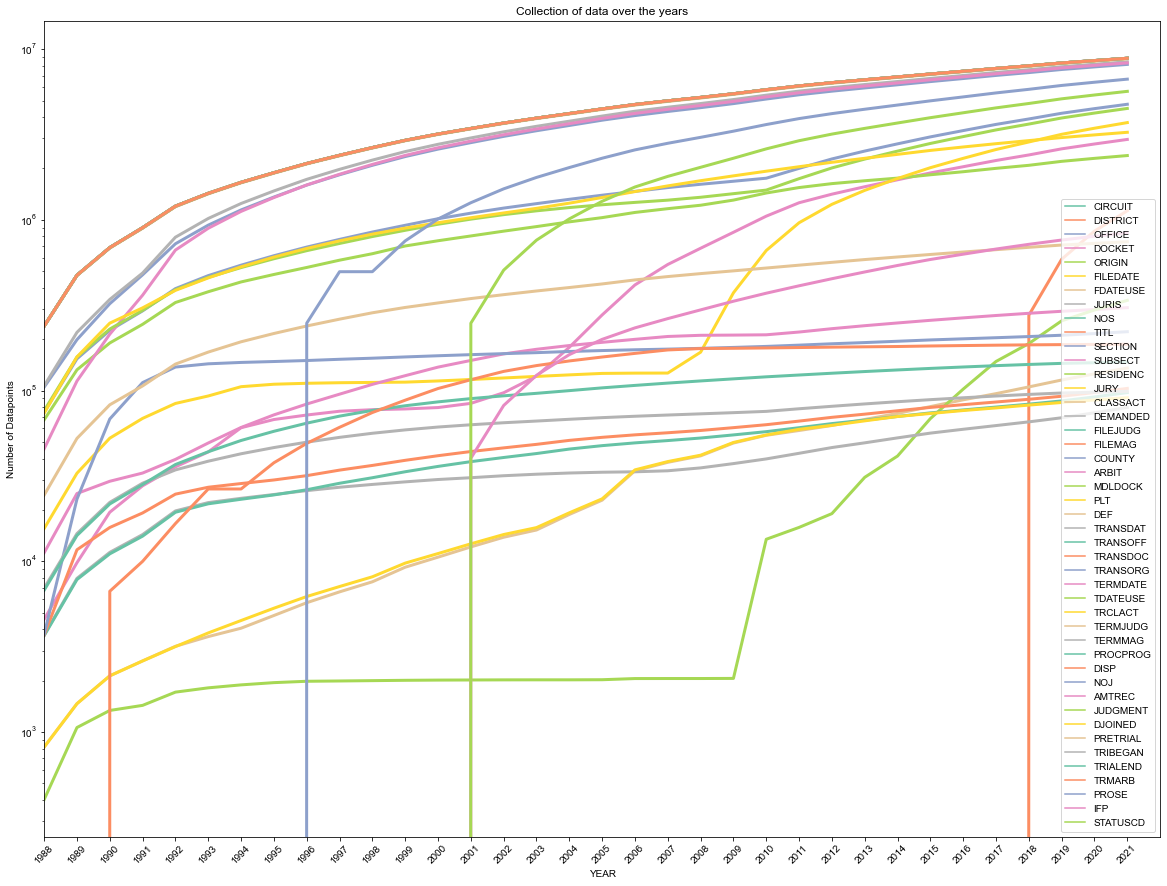

In [13]:
plt.figure(figsize=(20,15))
ax = sns.lineplot(data=df_timeline_cumm,dashes=False,linewidth=3,palette='Set2')
sns.set_style('white')

## Labels and Title
ax.set(xlabel="YEAR",ylabel="Number of Datapoints",title="Collection of data over the years")

## Axes limits, ticks and Scale
ax.set(xlim=(1988,2022) , xticks=(range(1988,2022)),yscale='log')
#ax.set(ylim=(0,10000000) , yticks=[0,10000000])
plt.xticks(rotation=45) #ax.set do not work as it needs xticks names too
plt.show()

In [14]:
df.replace({"JUDGMENT":{0:np.nan,4:np.nan}},inplace=True)
df.head()


,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,JUDGMENT,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR
0,0,90,1,7101462,4.0,07/21/1971,07/01/1971,3.0,440,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
1,0,90,1,7300974,4.0,05/17/1973,02/01/1983,2.0,890,NaN,...,1.0,01/20/1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
2,0,90,1,7601326,4.0,01/31/1985,06/01/1985,2.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
3,0,90,1,7700081,3.0,09/19/1984,05/01/1986,2.0,442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988
4,0,90,1,7901559,2.0,06/15/1979,06/01/1979,2.0,550,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988


In [ ]:
def replace_value_from_ncolumns(data,columns,value,newvalue):
  for cols in columns:
    data.replace({cols:{value:newvalue}}, inplace=True)

#replace_value_from_ncolumns(df,("DEMANDED","AMTREC"),9999,np.nan)

In [16]:
df["LABEL"] = df["NOJ"] + (df["JUDGMENT"]*10)
#to_drop = ['NOJ','JUDGMENT']
df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,FILEDATE,FDATEUSE,JURIS,NOS,TITL,...,DJOINED,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR,LABEL
0,0,90,1,7101462,4.0,07/21/1971,07/01/1971,3.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,13.0
1,0,90,1,7300974,4.0,05/17/1973,02/01/1983,2.0,890,NaN,...,01/20/1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,11.0
2,0,90,1,7601326,4.0,01/31/1985,06/01/1985,2.0,440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,NaN
3,0,90,1,7700081,3.0,09/19/1984,05/01/1986,2.0,442,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,NaN
4,0,90,1,7901559,2.0,06/15/1979,06/01/1979,2.0,550,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,20.0


In [17]:
df["TERMDATE"]= pd.to_datetime(df["TERMDATE"])
df["FILEDATE"]= pd.to_datetime(df["FILEDATE"])
df["CASEDAYS"] = (df["TERMDATE"]-df["FILEDATE"]).dt.days
to_drop = ['TERMDATE','FILEDATE','FDATEUSE']
df.drop(to_drop, inplace=True,axis=1)
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,TITL,SECTION,SUBSECT,...,PRETRIAL,TRIBEGAN,TRIALEND,TRMARB,PROSE,IFP,STATUSCD,TAPEYEAR,LABEL,CASEDAYS
0,0,90,1,7101462,4.0,3.0,440,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,13.0,5233.0
1,0,90,1,7300974,4.0,2.0,890,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,11.0,5450.0
2,0,90,1,7601326,4.0,2.0,440,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,NaN,1145.0
3,0,90,1,7700081,3.0,2.0,442,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,NaN,395.0
4,0,90,1,7901559,2.0,2.0,550,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,20.0,3100.0


In [35]:
missing_value_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_value_count.sum()
total_percentage_missing = (total_missing/total_cells)*100
percent_missing = round(df.isnull().mean()*100,1)
missing_value_count = missing_value_count.to_frame().merge(percent_missing.to_frame(), left_index=True, right_index=True)
print("Missing Values Count:")
print(missing_value_count)
print("\nTotal Percentage of missing data:",round(total_percentage_missing,2),'%')

Missing Values Count:
              0_x    0_y
CIRCUIT         0    0.0
DISTRICT        0    0.0
OFFICE          0    0.0
DOCKET          0    0.0
ORIGIN        550    0.0
JURIS           1    0.0
NOS             0    0.0
TITL      7713876   87.2
SECTION    700494    7.9
SUBSECT   5884914   66.5
RESIDENC  6463161   73.1
JURY      5130193   58.0
CLASSACT  8709326   98.5
DEMANDED   411258    4.6
FILEJUDG  8844856  100.0
FILEMAG   8844856  100.0
COUNTY          0    0.0
ARBIT     8538791   96.5
MDLDOCK   8507082   96.2
PLT         23836    0.3
DEF         50404    0.6
TRANSDAT  8765227   99.1
TRANSOFF  8747539   98.9
TRANSDOC  8741885   98.8
TRANSORG  8623563   97.5
TDATEUSE        5    0.0
TRCLACT   8753954   99.0
TERMJUDG  8844856  100.0
TERMMAG   8844856  100.0
PROCPROG        5    0.0
DISP            5    0.0
AMTREC     537458    6.1
DJOINED   5585820   63.2
PRETRIAL  8100160   91.6
TRIBEGAN  8745876   98.9
TRIALEND  8697969   98.3
TRMARB    8658028   97.9
PROSE     2170904   24.5
IFP

In [36]:
#Sort transposed describe() by count
df.describe(include='object').T.sort_values(by=['count']).head(10)

,count,unique,top,freq
TRANSDAT,79629,7153,01/01/2010,1240
TRANSOFF,97317,31,3,19778
TRIBEGAN,98980,8296,07/13/1987,130
TRIALEND,146887,9469,08/10/1987,101
TRMARB,186828,4,E,112077
TRANSORG,221293,18,1,169688
ARBIT,306065,33,E,180083
MDLDOCK,337774,910,2327,48269
PRETRIAL,744696,11697,10/07/2015,4158
IFP,839868,1,FP,839868


<AxesSubplot:>

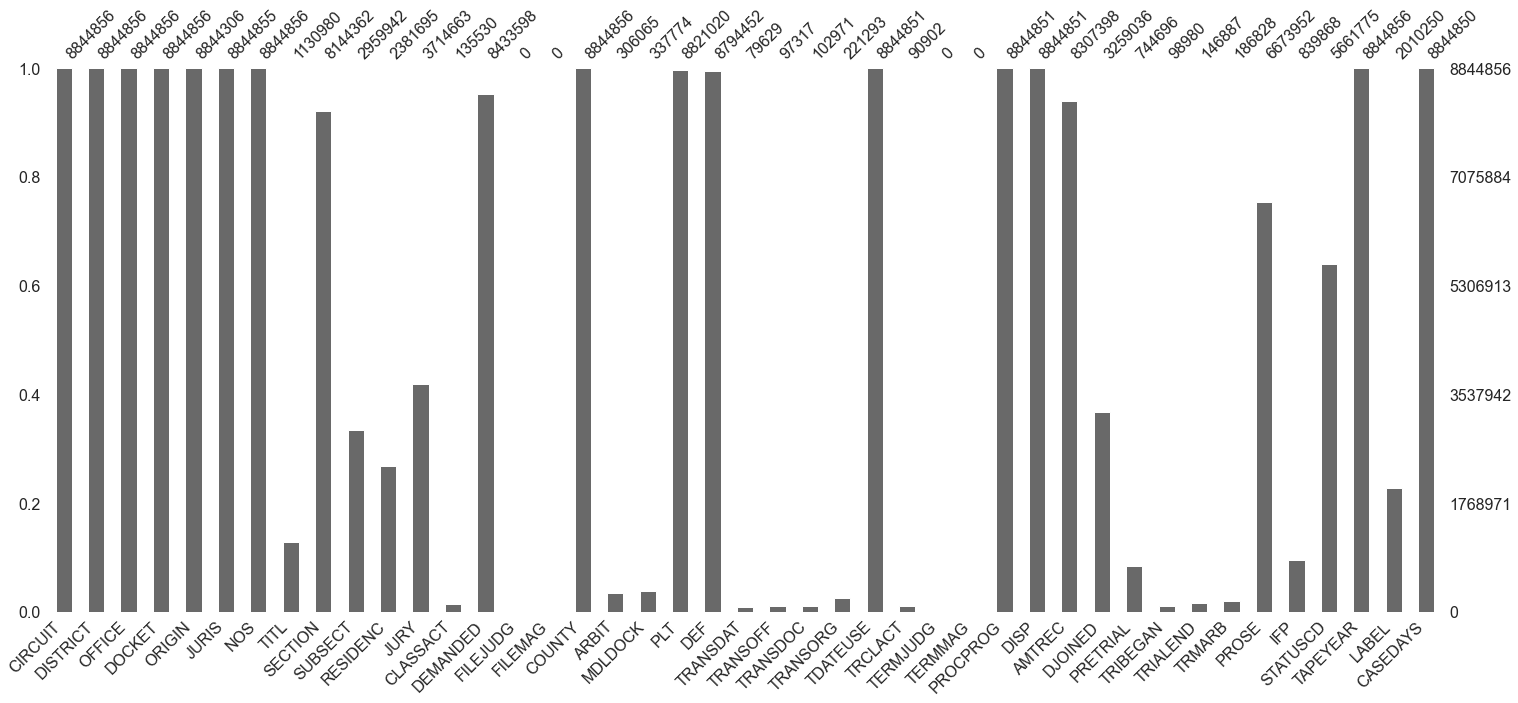

In [18]:
msno.bar(df)

'\nHeatmap:\nThe heatmap is used to identify correlations of the nullity between each of the different columns. In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.\nValues close to positive 1 indicate that the presence of null values in one column is correlated with the presence of null values in another column.\nValues close to negative 1 indicate that the presence of null values in one column is anti-correlated with the presence of null values in another column. In other words, when null values are present in one column, there are data values present in the other column, and vice versa.\nValues close to 0, indicate there is little to no relationship between the presence of null values in one column compared to another.\nThere are a number of values that show as <-1. This indicates that the correlation is very close to being 100% negative.\n'

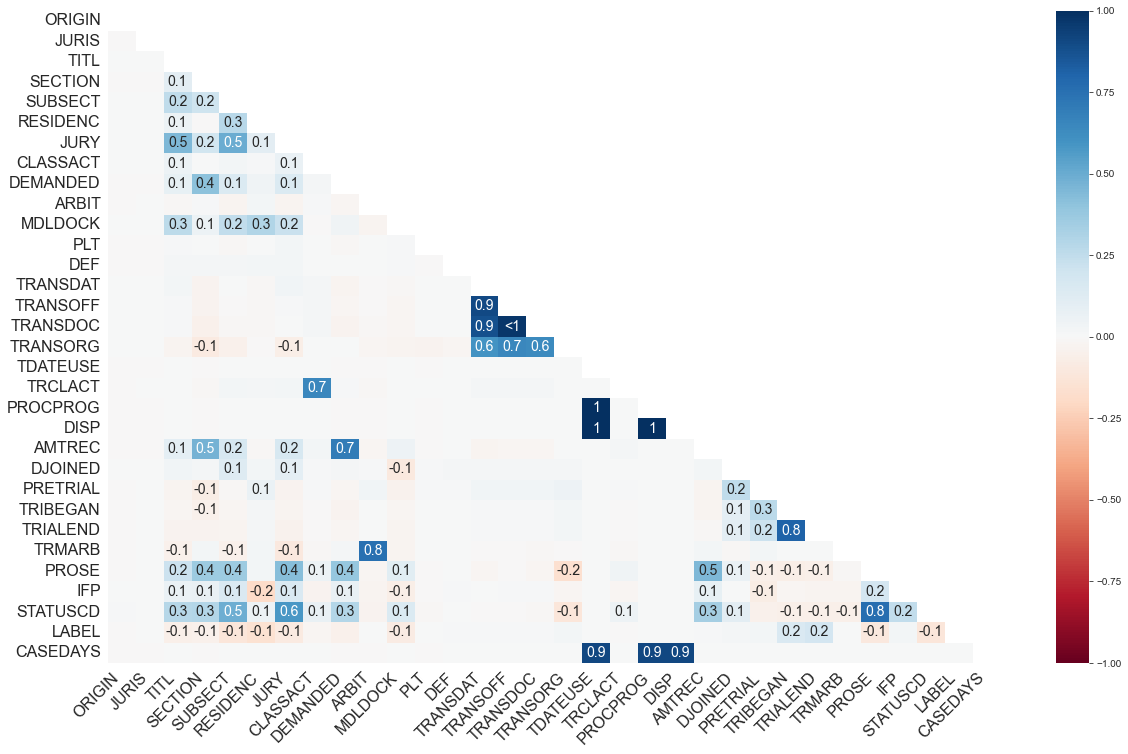

In [43]:
msno.heatmap(df)
'''
Heatmap:
The heatmap is used to identify correlations of the nullity between each of the different columns. In other words, it can be used to identify if there is a relationship in the presence of null values between each of the columns.
Values close to positive 1 indicate that the presence of null values in one column is correlated with the presence of null values in another column.
Values close to negative 1 indicate that the presence of null values in one column is anti-correlated with the presence of null values in another column. In other words, when null values are present in one column, there are data values present in the other column, and vice versa.
Values close to 0, indicate there is little to no relationship between the presence of null values in one column compared to another.
There are a number of values that show as <-1. This indicates that the correlation is very close to being 100% negative.
'''

<AxesSubplot:>

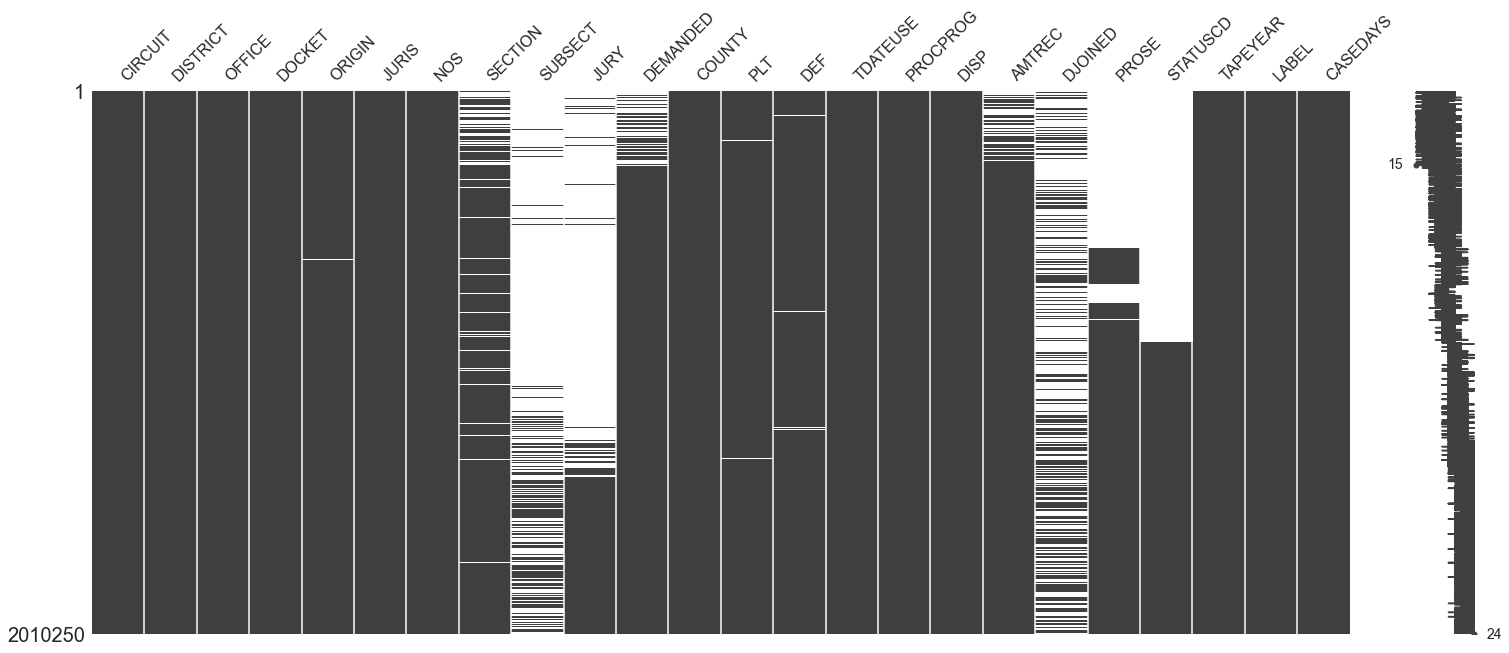

In [22]:
msno.matrix(df)

In [19]:
print("Old Shape:",df.shape)
df.dropna(subset=["LABEL"],inplace=True)
threshold = len(df)*0.20
print("Removing columnns which do not have atleast", round(threshold/len(df)),"% percent datapoints.")
df.dropna(axis=1,thresh=threshold,inplace=True)
#df = df.dropna(how='any',axis=0)
print("New Shape:",df.shape)

Old Shape: (8844856, 43)
Removing columnns which do not have atleast 0.0 % percent datapoints.
New Shape: (2010250, 24)


In [20]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 24 columns and 2010250 Rows.
There are 11 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
SUBSECT,0,1545403,76.9,1545403,76.9,object
JURY,0,1324480,65.9,1324480,65.9,object
DJOINED,0,1240096,61.7,1240096,61.7,object
STATUSCD,0,932651,46.4,932651,46.4,object
PROSE,811993,658743,32.8,1470736,73.2,float64
SECTION,0,209744,10.4,209744,10.4,object
DEMANDED,1398645,130062,6.5,1528707,76.0,float64
AMTREC,1456521,112310,5.6,1568831,78.0,float64
DEF,0,8107,0.4,8107,0.4,object
PLT,0,4296,0.2,4296,0.2,object


<AxesSubplot:>

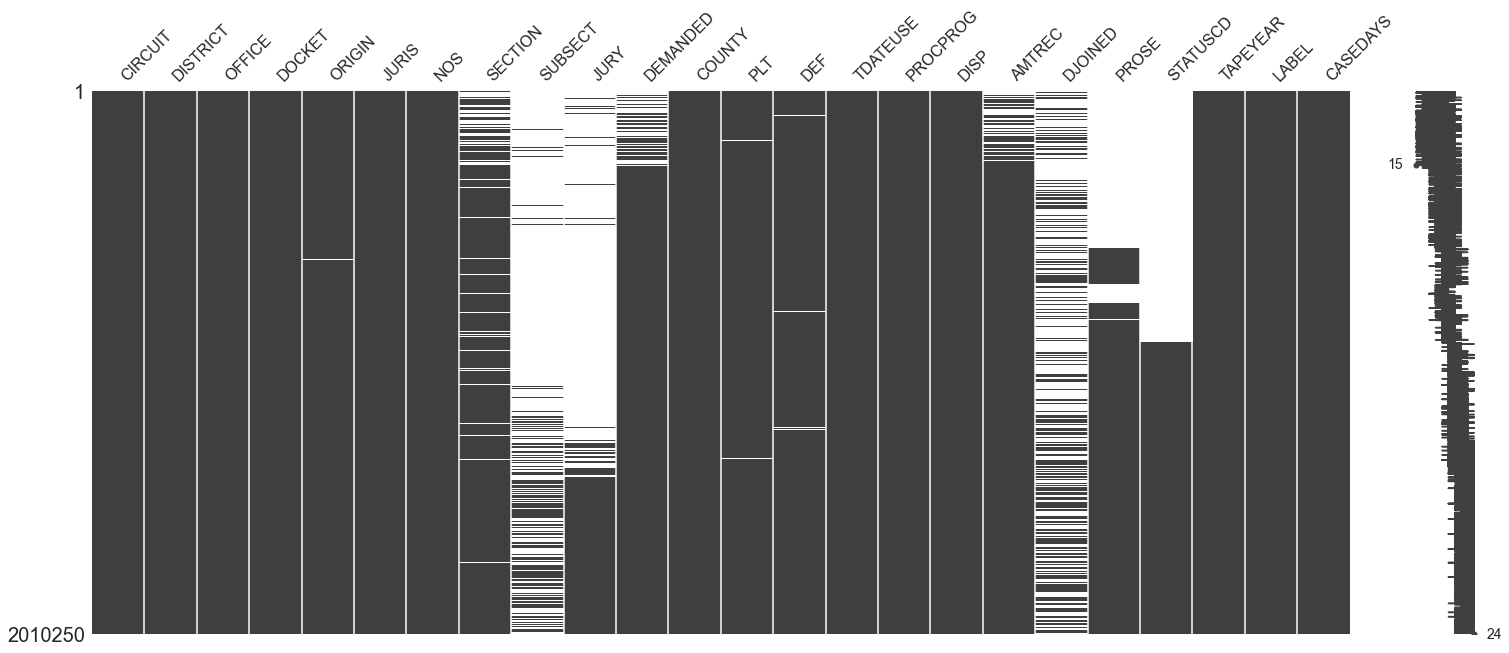

In [21]:
msno.matrix(df)

Old Shape: (2010250, 24)
New Shape: (1039966, 24)


<AxesSubplot:>

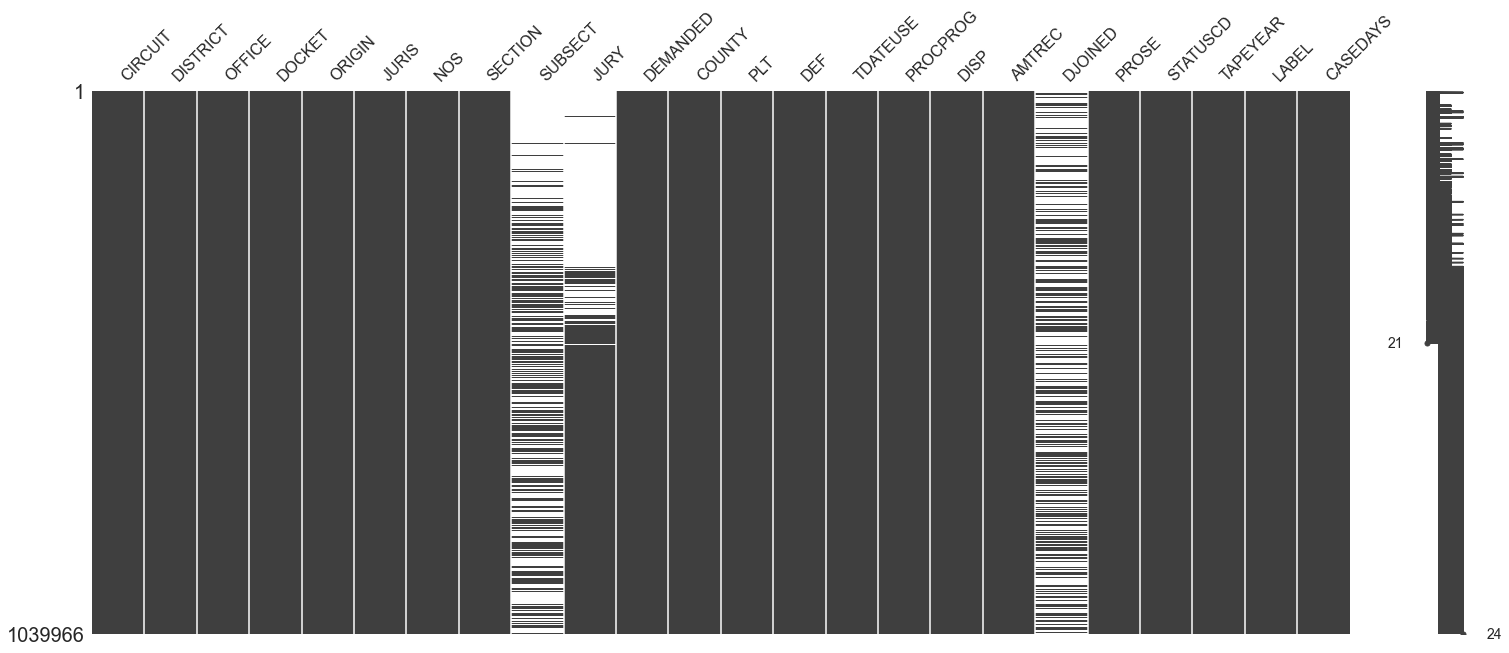

In [23]:
print("Old Shape:",df.shape)
df.dropna(subset=["STATUSCD","SECTION","PLT","DEF","PROSE"],inplace=True)
print("New Shape:",df.shape)
msno.matrix(df)

<AxesSubplot:>

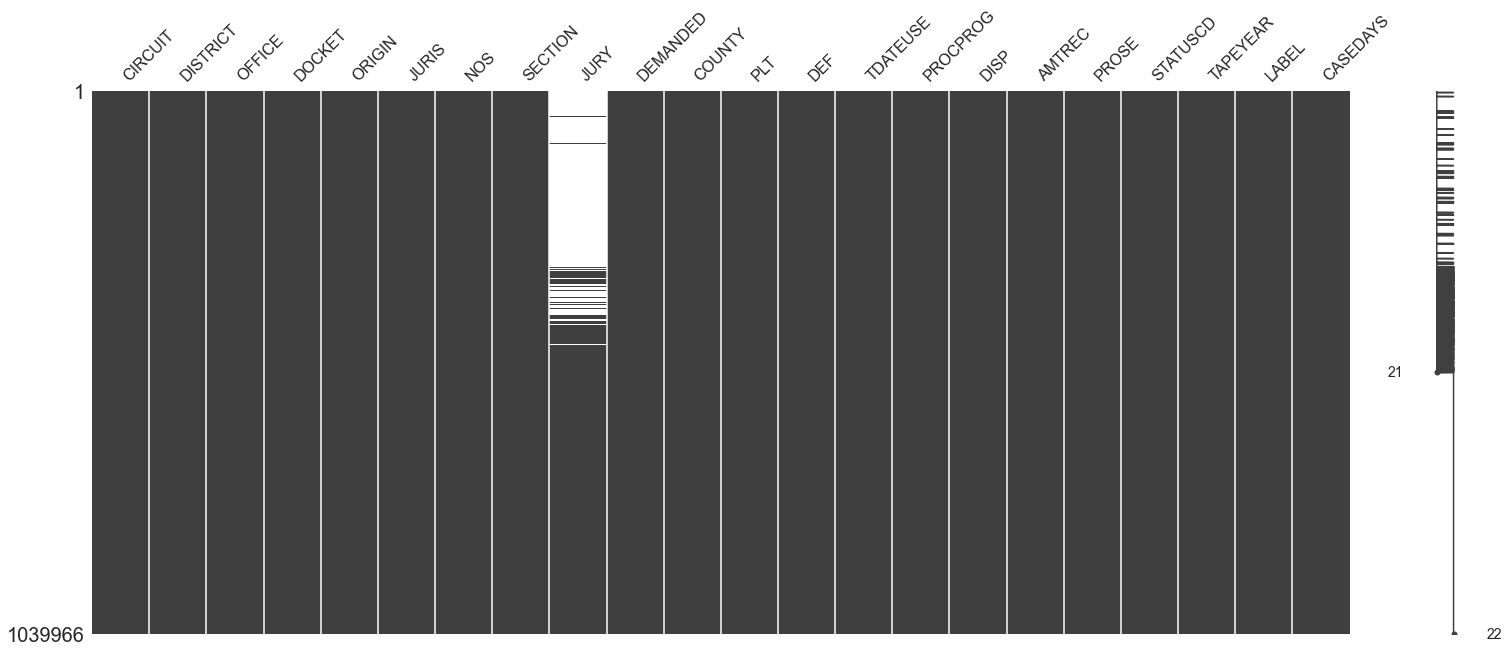

In [24]:
df= df.drop(columns=["DJOINED","SUBSECT"])
msno.matrix(df)

In [25]:
missing_zero_values_table(df)

Your selected dataframe has 22 columns and 1039966 Rows.
There are 1 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
JURY,0,390208,37.5,390208,37.5,object


## Imputation

In [108]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,...,PROCPROG,DISP,AMTREC,PROSE,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL
3183092,0,90,1,43,1.0,3.0,740,0151,NaN,0.0,...,4.0,6.0,0.0,0.0,L,2001,10.0,446.0,True,True
3183095,0,90,1,66,1.0,2.0,893,0551,NaN,0.0,...,4.0,17.0,0.0,0.0,L,2001,30.0,444.0,True,True
3183099,0,90,1,73,1.0,2.0,890,1395,NaN,0.0,...,4.0,6.0,0.0,0.0,L,2001,10.0,511.0,True,False
3183100,0,90,1,74,1.0,3.0,442,2003,NaN,2000.0,...,5.0,6.0,0.0,2.0,L,2001,20.0,282.0,False,True
3183104,0,90,1,79,1.0,2.0,863,0405,NaN,0.0,...,4.0,6.0,0.0,0.0,L,2001,20.0,264.0,False,False


In [49]:
get_column_stats("STATUSCD")

Number of NaN: 0
Percentage of NaN: 0.0 %
Number of Unique Values:  1 

Unique Values:  ['L'] 

Description of Column:
 count          1.0
mean     1039966.0
std            NaN
min      1039966.0
25%      1039966.0
50%      1039966.0
75%      1039966.0
max      1039966.0
Name: STATUSCD, dtype: float64

Top  Value Count:  
 L    1039966
Name: STATUSCD, dtype: int64

|  25% of STATUSCD column's data appear in 1039966 rows at most 

|  50% of STATUSCD column's data appear in 1039966 rows at most 


## NLP

In [26]:
df["PLT_ETAL"] = df["PLT"].str.contains("ETAL|ET AL")
df["DEF_ETAL"] = df["DEF"].str.contains("ETAL|ET AL")

In [27]:
df["PLT"].info()

<class 'pandas.core.series.Series'>
Int64Index: 1039966 entries, 3183092 to 9474367
Series name: PLT
Non-Null Count    Dtype 
--------------    ----- 
1039966 non-null  object
dtypes: object(1)
memory usage: 15.9+ MB


In [34]:
nlp = spacy.load('en_core_web_sm', disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

def get_orgs(doc):
    org_list = []
    for entity in doc.ents:
        if entity.label_ == 'ORG'or'PERSON'or'GPE':
            org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # set() to remove duplicates then convert back to list
    org_list = list(set(org_list))
    return org_list 

def preprocess_pipe_org(text):
    preproc_pipe_org = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe_org.append(get_orgs(doc))
    return preproc_pipe_org

In [32]:
def get_person(doc):
    person_list = []
    for entity in doc.ents:
        if entity.label_ == 'PERSON':
            org_list.append(entity.text)
    # if organization is identified more than once it will appear multiple times in list
    # set() to remove duplicates then convert back to list
    person_list = list(set(person_list))
    return person_list 

def preprocess_pipe_person(text):
    preproc_pipe = []
    for doc in nlp.pipe(text, batch_size=100000, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        preproc_pipe.append(get_person(doc))
    return preproc_pipe_person

In [35]:
df["PLT_ORG"] = preprocess_pipe_org(df['PLT'])
df["DEF_ORG"] = preprocess_pipe_org(df['DEF'])

In [ ]:
df["PLT_PERSON"] = preprocess_pipe_person(df['PLT'])
df["DEF_PERSON"] = preprocess_pipe_person(df['DEF'])

In [38]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,...,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_ORG_FLAG,DEF_ORG_FLAG
3183092,0,90,1,43,1.0,3.0,740,0151,NaN,0.0,...,L,2001,10.0,446.0,True,True,[ET AL],"[ET AL, BURLINGTON NORTHERN]",True,True
3183095,0,90,1,66,1.0,2.0,893,0551,NaN,0.0,...,L,2001,30.0,444.0,True,True,"[CITY/WILLIAMS, ET AL, ARIZO]",[ET AL],True,True
3183099,0,90,1,73,1.0,2.0,890,1395,NaN,0.0,...,L,2001,10.0,511.0,True,False,"[LOS ANGELES CO/DHS, ET AL]",[SHALALA],True,True
3183100,0,90,1,74,1.0,3.0,442,2003,NaN,2000.0,...,L,2001,20.0,282.0,False,True,[DAVIS],"[SECURIT, COASTAL INTL, ET AL]",True,True
3183104,0,90,1,79,1.0,2.0,863,0405,NaN,0.0,...,L,2001,20.0,264.0,False,False,[],[],False,False


In [37]:
df["PLT_ORG_FLAG"] = df["PLT_ORG"].str.len() > 0
df["DEF_ORG_FLAG"] = df["DEF_ORG"].str.len() > 0

In [39]:
def remove_brackets_from_column(columns):
  for cols in columns:
    df[cols] = df[cols].str[0]

remove_brackets_from_column(['PLT_ORG','DEF_ORG'])

In [45]:
df["PLT_ORG"] = df["PLT_ORG"].str.replace('ET AL','')
df["DEF_ORG"] = df["DEF_ORG"].str.replace('ET AL','')

In [46]:
df.head(40)

,CIRCUIT,DISTRICT,OFFICE,DOCKET,ORIGIN,JURIS,NOS,SECTION,JURY,DEMANDED,...,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_ORG_FLAG,DEF_ORG_FLAG
3183092,0,90,1,43,1.0,3.0,740,0151,NaN,0.0,...,L,2001,10.0,446.0,True,True,,,True,True
3183095,0,90,1,66,1.0,2.0,893,0551,NaN,0.0,...,L,2001,30.0,444.0,True,True,CITY/WILLIAMS,,True,True
3183099,0,90,1,73,1.0,2.0,890,1395,NaN,0.0,...,L,2001,10.0,511.0,True,False,LOS ANGELES CO/DHS,SHALALA,True,True
3183100,0,90,1,74,1.0,3.0,442,2003,NaN,2000.0,...,L,2001,20.0,282.0,False,True,DAVIS,SECURIT,True,True
3183104,0,90,1,79,1.0,2.0,863,0405,NaN,0.0,...,L,2001,20.0,264.0,False,False,NaN,NaN,False,False
3183105,0,90,1,82,1.0,3.0,442,2000,NaN,300.0,...,L,2001,20.0,350.0,False,False,BATTLE,WMATA,True,True
3183106,0,90,1,103,1.0,3.0,555,1983,NaN,0.0,...,L,2001,20.0,560.0,False,True,GLOVER,,True,True
3183108,0,90,1,105,1.0,2.0,550,0552,NaN,0.0,...,L,2001,20.0,618.0,False,False,RUIZ,NaN,True,False
3183109,0,90,1,108,1.0,3.0,555,1983,NaN,750.0,...,L,2001,20.0,505.0,False,True,GLOVER,,True,True
3183113,0,90,1,115,1.0,2.0,442,2000,NaN,300.0,...,L,2001,10.0,436.0,False,False,NaN,NaN,False,False


In [52]:
df.to_csv("LLcleaned.csv", sep='\t',header=True)

In [51]:
get_column_stats("PLT_ORG")

Number of NaN: 391364
Percentage of NaN: 37.63 %
Number of Unique Values:  109079 

Unique Values:  ['' 'CITY/WILLIAMS' 'LOS ANGELES CO/DHS' ... 'ONE HUNDRED MILES' 'JARJOUR'
 'MONITRONICS INTERNATIONAL INC'] 

Description of Column:
 count    109079.000000
mean          5.946167
std         327.655367
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max       88485.000000
Name: PLT_ORG, dtype: float64

Top  Value Count:  
                                  88485
UNITED STATES OF AMERICA         50630
USA                              31480
UNITED STATES                     7920
WILLIAMS                          7662
                                 ...  
ANTHOS                               1
NORTHEASTERN                         1
VAN AUKEN                            1
VACCO                                1
MONITRONICS INTERNATIONAL INC        1
Name: PLT_ORG, Length: 109079, dtype: int64

|  25% of PLT_ORG column's data appear in 1 rows at mos

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1039966 entries, 3183092 to 9474367
Data columns (total 28 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   CIRCUIT       1039966 non-null  int8   
 1   DISTRICT      1039966 non-null  object 
 2   OFFICE        1039966 non-null  object 
 3   DOCKET        1039966 non-null  int32  
 4   ORIGIN        1039966 non-null  float64
 5   JURIS         1039966 non-null  float64
 6   NOS           1039966 non-null  int16  
 7   SECTION       1039966 non-null  object 
 8   JURY          649758 non-null   object 
 9   DEMANDED      1039966 non-null  float64
 10  COUNTY        1039966 non-null  int32  
 11  PLT           1039966 non-null  object 
 12  DEF           1039966 non-null  object 
 13  TDATEUSE      1039966 non-null  object 
 14  PROCPROG      1039966 non-null  float64
 15  DISP          1039966 non-null  float64
 16  AMTREC        1039966 non-null  float64
 17  PROSE         1039966

In [53]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE', 'DOCKET','ORIGIN', 'JURIS', 'NOS','SECTION','JURY','COUNTY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()

CIRCUIT             12
DISTRICT           150
OFFICE              10
DOCKET          246349
ORIGIN              13
JURIS                5
NOS                107
SECTION           1273
JURY                 5
COUNTY            3182
PROCPROG            13
DISP                19
PROSE                4
STATUSCD             1
PLT_ETAL             2
DEF_ETAL             2
PLT_ORG_FLAG         2
DEF_ORG_FLAG         2
dtype: int64

In [54]:
get_column_stats("DISTRICT")

Number of NaN: 0
Percentage of NaN: 0.0 %
Number of Unique Values:  150 

Unique Values:  ['90' '00' '01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12'
 '13' '14' '15' '16' '17' '18' '19' '20' '22' '23' '24' '25' '3L' '3N'
 '36' '37' '38' '39' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49'
 '50' '51' '52' '53' '54' '55' '57' '60' '61' '62' '63' '64' '65' '66'
 '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79' '80'
 '81' '93' '94' '82' '83' '84' '85' '86' '87' '88' '89' '26' '27' '28'
 '29' '3A' '3C' '3E' '3G' '3J' '56' '7-' '91' '58' 8 9 10 11 12 13 14 6 7
 15 3 4 5 91 16 17 18 19 20 22 23 24 25 47 48 49 50 51 52 53 54 55 56 57
 58 60 61 62 63 64 80 81 93 94 82 83 84 85 86 87 88 89 26 27 28 29] 

Description of Column:
 count      150.000000
mean      6933.106667
std       9576.335115
min          4.000000
25%        463.750000
50%       3183.500000
75%       9905.750000
max      58003.000000
Name: DISTRICT, dtype: float64

Top  Value Count:  
 73    58003
08

In [55]:
df['DISTRICT'] = df['DISTRICT'].replace(['3A','3C','3E','3G','3J','3L','3N','7-'],['30','31','32','33','34','35','96','95'])
df["DISTRICT"] = df["DISTRICT"].astype(int)

In [56]:
get_column_stats("DISTRICT")

Number of NaN: 0
Percentage of NaN: 0.0 %
Number of Unique Values:  94 

Unique Values:  [90  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23
 24 25 35 96 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 57 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 93
 94 82 83 84 85 86 87 88 89 26 27 28 29 30 31 32 33 34 56 95 91 58] 

Description of Column:
 count       94.000000
mean     11063.468085
std      11122.658997
min         96.000000
25%       3659.500000
50%       7862.000000
75%      13432.750000
max      58003.000000
Name: DISTRICT, dtype: float64

Top  Value Count:  
 73    58003
8     55920
52    40961
70    37480
30    33487
      ...  
95     1447
89     1378
91      300
93      266
94       96
Name: DISTRICT, Length: 94, dtype: int64

|  25% of DISTRICT column's data appear in 3660 rows at most 

|  50% of DISTRICT column's data appear in 7862 rows at most 


In [57]:
get_column_stats("DOCKET")

Number of NaN: 0
Percentage of NaN: 0.0 %
Number of Unique Values:  246349 

Unique Values:  [     43      66      73 ... 2103586 2103974 2103982] 

Description of Column:
 count    246349.000000
mean          4.221515
std           6.420204
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          66.000000
Name: DOCKET, dtype: float64

Top  Value Count:  
 800064     66
1300034    64
100017     64
1000039    63
1200014    62
           ..
1011326     1
1011275     1
1011191     1
1011164     1
2103982     1
Name: DOCKET, Length: 246349, dtype: int64

|  25% of DOCKET column's data appear in 1 rows at most 

|  50% of DOCKET column's data appear in 2 rows at most 


In [58]:
df= df.drop(columns=["DOCKET","COUNTY","SECTION"])

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

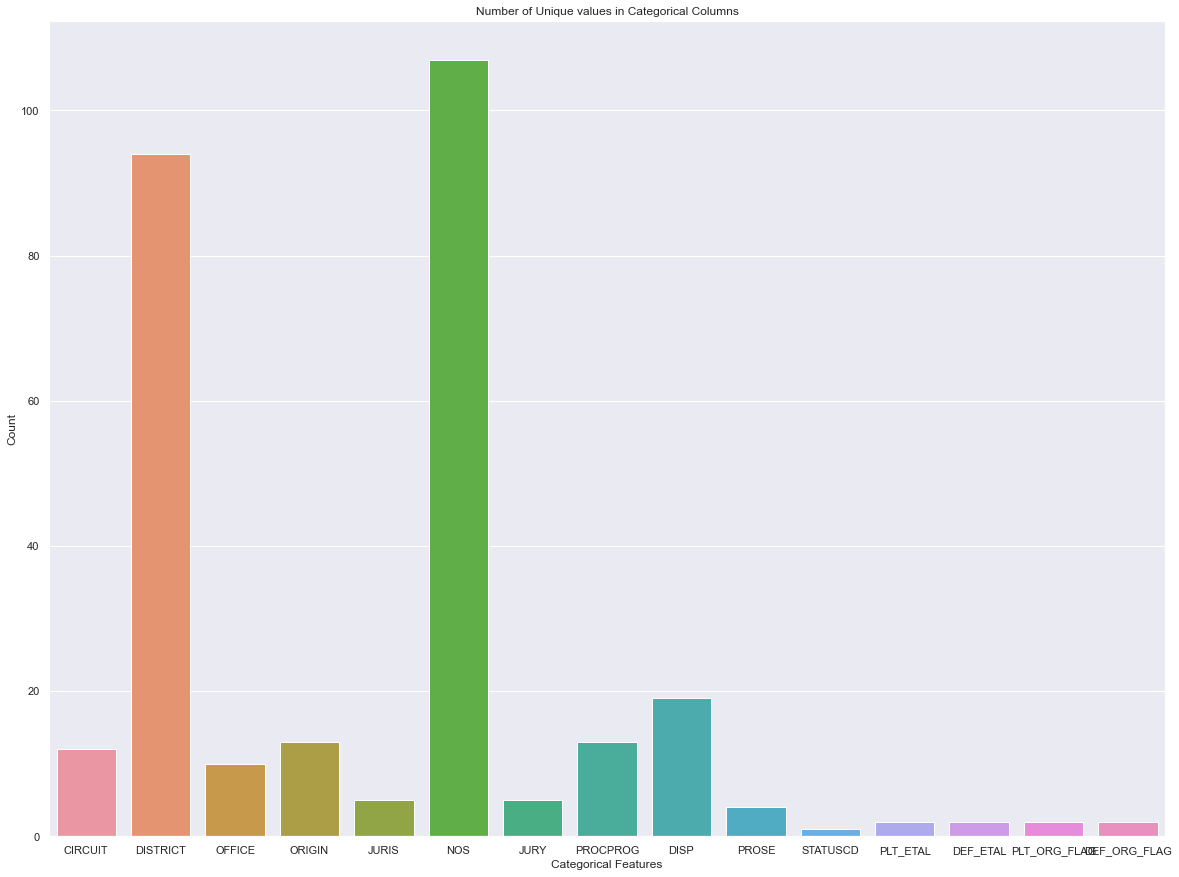

In [59]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()
sns.set(rc={'figure.figsize':(20,15)})
x_uni = df_cat.nunique().index
y_uni = df_cat.nunique().values
ax=sns.barplot(x_uni,y_uni)
##ax.set_yscale("log") ## If values are large
ax.set_title("Number of Unique values in Categorical Columns")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Count")

In [60]:
def freq_map_encoding(column,percent_remove):
  freq = df[column].value_counts(normalize=True)
  mapping = df[column].map(freq)
  df[column] = df[column].mask(mapping < (percent_remove/100), 'Other')
  return df[column]

## column in format: 'column'
## percent_remove: 1 for 1%

In [61]:
cols_to_freq_map = ["NOS","DISTRICT","JURY"]
for cols in cols_to_freq_map:
  df[cols] = freq_map_encoding(cols,2)

In [381]:
df.to_csv("LLrawdata2.csv")

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

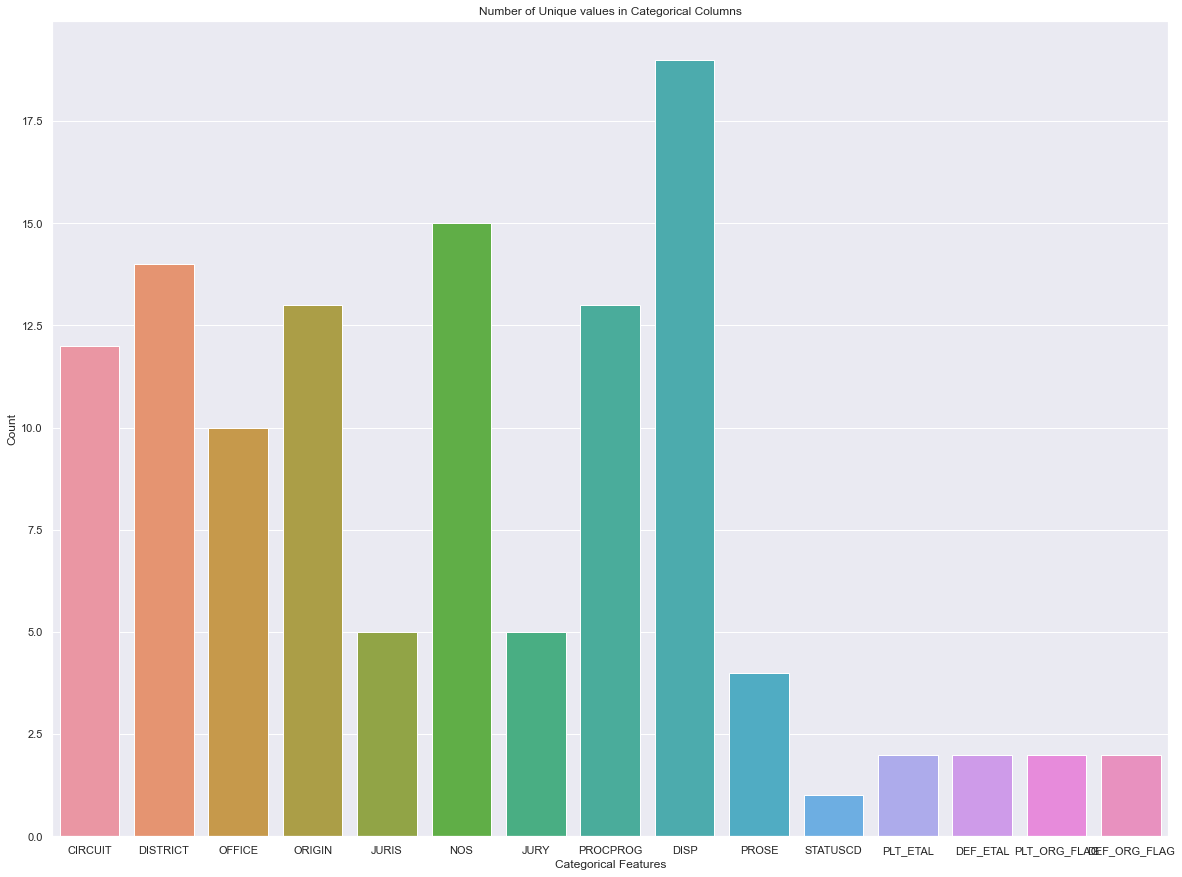

In [62]:
categorical_cols = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROCPROG','DISP','PROSE','STATUSCD', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']
df_cat = df[categorical_cols].copy()
df_cat.nunique()
sns.set(rc={'figure.figsize':(20,15)})
x_uni = df_cat.nunique().index
y_uni = df_cat.nunique().values
ax=sns.barplot(x_uni,y_uni)
##ax.set_yscale("log") ## If values are large
ax.set_title("Number of Unique values in Categorical Columns")
ax.set_xlabel("Categorical Features")
ax.set_ylabel("Count")

In [63]:
df.head()

,CIRCUIT,DISTRICT,OFFICE,ORIGIN,JURIS,NOS,JURY,DEMANDED,PLT,DEF,...,STATUSCD,TAPEYEAR,LABEL,CASEDAYS,PLT_ETAL,DEF_ETAL,PLT_ORG,DEF_ORG,PLT_ORG_FLAG,DEF_ORG_FLAG
3183092,0,Other,1,1.0,3.0,Other,NaN,0.0,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",...,L,2001,10.0,446.0,True,True,,,True,True
3183095,0,Other,1,1.0,2.0,Other,NaN,0.0,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",...,L,2001,30.0,444.0,True,True,CITY/WILLIAMS,,True,True
3183099,0,Other,1,1.0,2.0,890,NaN,0.0,"LOS ANGELES CO/DHS, ET AL",SHALALA,...,L,2001,10.0,511.0,True,False,LOS ANGELES CO/DHS,SHALALA,True,True
3183100,0,Other,1,1.0,3.0,442,NaN,2000.0,DAVIS,"COASTAL INTL SECURIT, ET AL",...,L,2001,20.0,282.0,False,True,DAVIS,SECURIT,True,True
3183104,0,Other,1,1.0,2.0,863,NaN,0.0,YOUNG,APFEL,...,L,2001,20.0,264.0,False,False,NaN,NaN,False,False


In [190]:
df.columns

Index(['CIRCUIT', 'DISTRICT', 'OFFICE', 'ORIGIN', 'JURIS', 'NOS', 'JURY',
       'DEMANDED', 'PLT', 'DEF', 'TDATEUSE', 'PROCPROG', 'DISP', 'AMTREC',
       'PROSE', 'STATUSCD', 'TAPEYEAR', 'LABEL', 'CASEDAYS', 'PLT_ETAL',
       'DEF_ETAL', 'PLT_ORG', 'DEF_ORG', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG',
       'JUDGMENT'],
      dtype='object')

In [ ]:
'''
a: predicting JUDGMENT
b: predicting AMTREC
c: predicting NOJ
'''

In [192]:
categorical_cols_a = ['CIRCUIT', 'DISTRICT', 'OFFICE','ORIGIN', 'JURIS', 'NOS','JURY','PROSE', 'PLT_ETAL', 'DEF_ETAL', 'PLT_ORG_FLAG', 'DEF_ORG_FLAG']

numerical_cols_a = ['DEMANDED','CASEDAYS']

label_col_a = ['JUDGMENT']

In [193]:
## One-Hot Encoding

df_a = pd.get_dummies(df, columns = categorical_cols)
df_a = df_a.reset_index()

/opt/homebrew/lib/python3.9/site-packages/pandas/core/algorithms.py:794: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [194]:
## Scaling numerical columns

df_a[numerical_cols] = MinMaxScaler().fit_transform(df_a[numerical_cols])

In [195]:
df_a["JUDGMENT"]= df_ohe["LABEL"].astype(str).str[0]
df_a["JUDGMENT"]= df_ohe["JUDGMENT"].astype(int)
#df_a.drop(columns=["LABEL"])

KeyError: 'LABEL'

In [196]:
df_ohe.head()
#df_ohe.drop(columns=["LABEL"],inplace=True)
df_ohe.columns
df_ohe["JUDGMENT"]

0          0
1          2
2          0
3          1
4          1
          ..
1039961    1
1039962    0
1039963    1
1039964    1
1039965    0
Name: JUDGMENT, Length: 1039966, dtype: int64

In [71]:
get_column_stats("JUDGMENT")

Number of NaN: 0
Percentage of NaN: 0.0 %
Number of Unique Values:  3 

Unique Values:  [1 3 2] 

Description of Column:
 count         3.000000
mean     346655.333333
std      325635.846550
min       27137.000000
25%      180942.000000
50%      334747.000000
75%      506414.500000
max      678082.000000
Name: JUDGMENT, dtype: float64

Top  Value Count:  
 2    678082
1    334747
3     27137
Name: JUDGMENT, dtype: int64

|  25% of JUDGMENT column's data appear in 180942 rows at most 

|  50% of JUDGMENT column's data appear in 334747 rows at most 


In [174]:
## Label Encoding

labelencoder = LabelEncoder()
df_ohe["LABEL"] = df_ohe["LABEL"].astype(int)
df_ohe["LABEL"] = labelencoder.fit_transform(df_ohe["LABEL"])
df_ohe.head(10)

,index,DEMANDED,PLT,DEF,TDATEUSE,AMTREC,TAPEYEAR,LABEL,CASEDAYS,PLT_ORG,...,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,3183092,0.000000,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",03/01/2001,0.0,2001,0,0.015091,ET AL,...,0,1,0,1,0,1,0,1,0,1
1,3183095,0.000000,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",03/01/2001,0.0,2001,14,0.015023,ARIZO,...,0,1,0,1,0,1,0,1,0,1
2,3183099,0.000000,"LOS ANGELES CO/DHS, ET AL",SHALALA,06/01/2001,0.0,2001,0,0.017290,LOS ANGELES CO/DHS,...,0,1,0,1,1,0,0,1,0,1
3,3183100,0.200020,DAVIS,"COASTAL INTL SECURIT, ET AL",10/01/2000,0.0,2001,7,0.009542,DAVIS,...,0,1,1,0,0,1,0,1,0,1
4,3183104,0.000000,YOUNG,APFEL,10/01/2000,0.0,2001,7,0.008932,NaN,...,0,1,1,0,1,0,1,0,1,0
5,3183105,0.030003,BATTLE,WMATA,12/01/2000,0.0,2001,7,0.011842,BATTLE,...,0,1,1,0,1,0,0,1,0,1
6,3183106,0.000000,GLOVER,"WASHINGTON, ET AL",07/01/2001,0.0,2001,7,0.018948,GLOVER,...,0,1,1,0,0,1,0,1,0,1
7,3183108,0.000000,RUIZ,DOJ,09/01/2001,0.0,2001,7,0.020910,RUIZ,...,0,1,1,0,1,0,0,1,1,0
8,3183109,0.075008,GLOVER,"WASHINGTON, ET AL",06/01/2001,0.0,2001,7,0.017087,GLOVER,...,0,1,1,0,0,1,0,1,0,1
9,3183113,0.030003,BASS,TANOUE,03/01/2001,0.0,2001,0,0.014752,NaN,...,0,1,1,0,1,0,1,0,1,0


In [198]:
## Label Encoding

labelencoder = LabelEncoder()
df_a["JUDGMENT"] = df_a["JUDGMENT"].astype(int)
df_a["JUDGMENT"] = labelencoder.fit_transform(df_a["JUDGMENT"])
df_a.head(10)

,index,DEMANDED,PLT,DEF,TDATEUSE,PROCPROG,DISP,AMTREC,STATUSCD,TAPEYEAR,...,PROSE_2.0,PROSE_3.0,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,3183092,0.000000,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",03/01/2001,4.0,6.0,0.0,L,2001,...,0,0,0,1,0,1,0,1,0,1
1,3183095,0.000000,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",03/01/2001,4.0,17.0,0.0,L,2001,...,0,0,0,1,0,1,0,1,0,1
2,3183099,0.000000,"LOS ANGELES CO/DHS, ET AL",SHALALA,06/01/2001,4.0,6.0,0.0,L,2001,...,0,0,0,1,1,0,0,1,0,1
3,3183100,0.200020,DAVIS,"COASTAL INTL SECURIT, ET AL",10/01/2000,5.0,6.0,0.0,L,2001,...,1,0,1,0,0,1,0,1,0,1
4,3183104,0.000000,YOUNG,APFEL,10/01/2000,4.0,6.0,0.0,L,2001,...,0,0,1,0,1,0,1,0,1,0
5,3183105,0.030003,BATTLE,WMATA,12/01/2000,4.0,6.0,0.0,L,2001,...,0,0,1,0,1,0,0,1,0,1
6,3183106,0.000000,GLOVER,"WASHINGTON, ET AL",07/01/2001,4.0,6.0,0.0,L,2001,...,0,0,1,0,0,1,0,1,0,1
7,3183108,0.000000,RUIZ,DOJ,09/01/2001,4.0,6.0,0.0,L,2001,...,0,0,1,0,1,0,0,1,1,0
8,3183109,0.075008,GLOVER,"WASHINGTON, ET AL",06/01/2001,4.0,6.0,0.0,L,2001,...,0,0,1,0,0,1,0,1,0,1
9,3183113,0.030003,BASS,TANOUE,03/01/2001,11.0,9.0,0.0,L,2001,...,0,0,1,0,1,0,1,0,1,0


In [199]:
df_a.columns

Index(['index', 'DEMANDED', 'PLT', 'DEF', 'TDATEUSE', 'PROCPROG', 'DISP',
       'AMTREC', 'STATUSCD', 'TAPEYEAR',
       ...
       'PROSE_2.0', 'PROSE_3.0', 'PLT_ETAL_False', 'PLT_ETAL_True',
       'DEF_ETAL_False', 'DEF_ETAL_True', 'PLT_ORG_FLAG_False',
       'PLT_ORG_FLAG_True', 'DEF_ORG_FLAG_False', 'DEF_ORG_FLAG_True'],
      dtype='object', length=101)

In [175]:
def df_column_switch(df, column1, column2):
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

In [176]:
df_column_switch(df_ohe, 'DEMANDED','LABEL')

,index,LABEL,PLT,DEF,TDATEUSE,AMTREC,TAPEYEAR,DEMANDED,CASEDAYS,PLT_ORG,...,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,3183092,0,"GENERAL COMM/ADJUST, ET AL","BURLINGTON NORTHERN, ET AL",03/01/2001,0.0,2001,0.000000,0.015091,ET AL,...,0,1,0,1,0,1,0,1,0,1
1,3183095,14,"CITY/WILLIAMS, ARIZO, ET AL","DOMBECK, ET AL",03/01/2001,0.0,2001,0.000000,0.015023,ARIZO,...,0,1,0,1,0,1,0,1,0,1
2,3183099,0,"LOS ANGELES CO/DHS, ET AL",SHALALA,06/01/2001,0.0,2001,0.000000,0.017290,LOS ANGELES CO/DHS,...,0,1,0,1,1,0,0,1,0,1
3,3183100,7,DAVIS,"COASTAL INTL SECURIT, ET AL",10/01/2000,0.0,2001,0.200020,0.009542,DAVIS,...,0,1,1,0,0,1,0,1,0,1
4,3183104,7,YOUNG,APFEL,10/01/2000,0.0,2001,0.000000,0.008932,NaN,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039961,9474305,7,WILLIAMS,"STATE OF GEORGIA, ET AL",08/01/2021,0.0,2021,0.030003,0.014989,WILLIAMS,...,0,1,1,0,0,1,0,1,0,1
1039962,9474327,3,MONITRONICS INTERNATIONAL INC.,MYERS,12/01/2020,0.0,2021,0.007501,0.004568,MONITRONICS INTERNATIONAL INC,...,0,1,1,0,1,0,0,1,1,0
1039963,9474341,7,KIRKLAND,"LAUGHLIN, ET AL",02/01/2021,0.0,2021,0.000000,0.005075,KIRKLAND,...,0,1,1,0,0,1,0,1,0,1
1039964,9474346,7,JOYNER,UNITED STATES OF AMERICA,06/01/2021,0.0,2021,0.000000,0.007917,NaN,...,0,1,1,0,1,0,1,0,0,1


In [164]:
## Lower memory size by downcasting

print("Dataframe Info before:\n")
df_ohe.info()
float_cols = df_ohe.select_dtypes('float').columns

int_cols = df_ohe.select_dtypes('integer').columns

df_ohe[float_cols] = df_ohe[float_cols].apply(pd.to_numeric, downcast='float')
df_ohe[int_cols] = df_ohe[int_cols].apply(pd.to_numeric, downcast='integer')
print("\n\nDataframe Info after:\n")
df_ohe.info()

Dataframe Info before:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039966 entries, 0 to 1039965
Columns: 130 entries, index to DEF_ORG_FLAG_True
dtypes: float64(3), int16(1), int64(2), object(5), uint8(119)
memory usage: 199.3+ MB


Dataframe Info after:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039966 entries, 0 to 1039965
Columns: 130 entries, index to DEF_ORG_FLAG_True
dtypes: float32(3), int16(1), int32(1), int8(120), object(5)
memory usage: 176.5+ MB


In [205]:
to_drop = ['AMTREC']
#to_drop = ['PLT', 'DEF', 'TDATEUSE', 'PLT_ORG', 'DEF_ORG','index','PROCPROG','TAPEYEAR','DISP','LABEL','STATUSCD',]
df_a = df_a.drop(columns=to_drop)
df_a.head()

,DEMANDED,CASEDAYS,JUDGMENT,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,...,PROSE_2.0,PROSE_3.0,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
0,0.00000,0.015091,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
1,0.00000,0.015023,2,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,1
2,0.00000,0.017290,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,1
3,0.20002,0.009542,1,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,1,0,1
4,0.00000,0.008932,1,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0


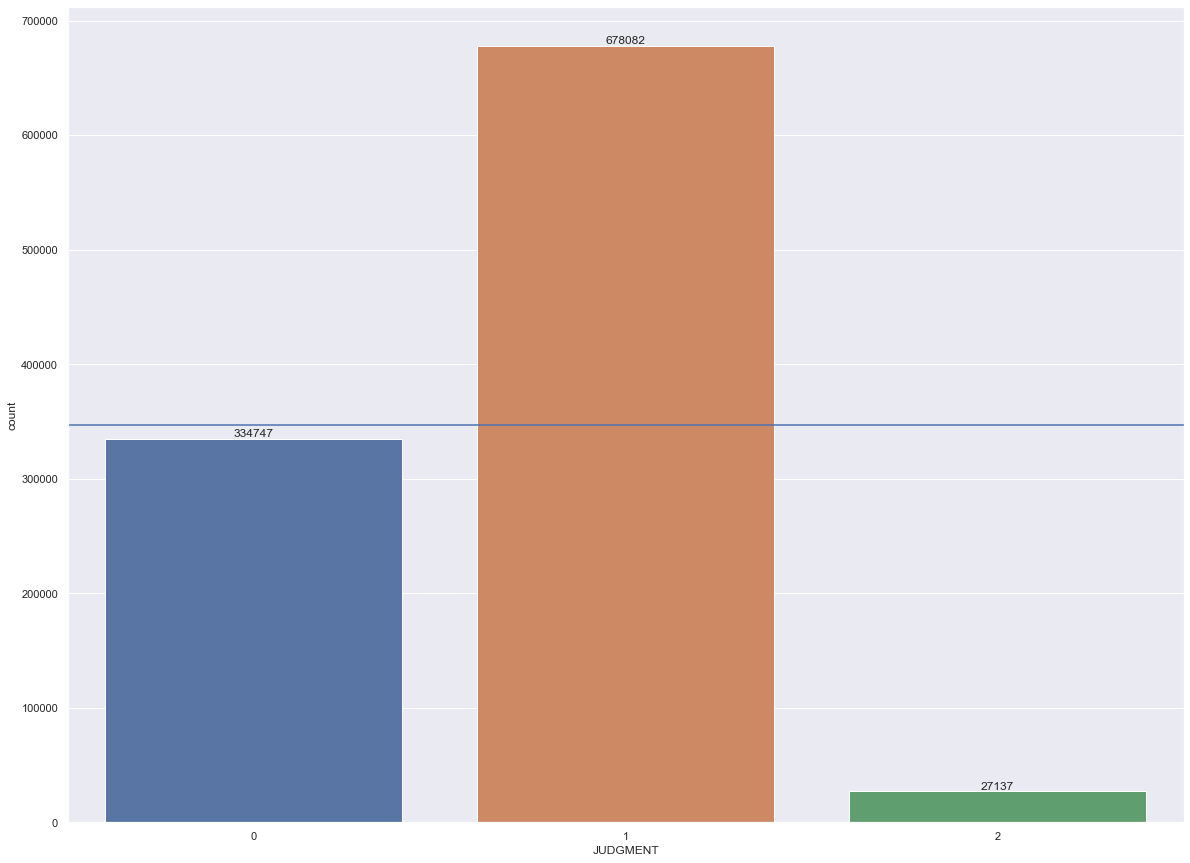

In [206]:
ax=sns.countplot(x="JUDGMENT",data=df_a,order=range(0,3))
#ax.set_yscale("log")
abs_values = df_a["JUDGMENT"].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0],labels=abs_values.sort())
ax.axhline(sum(abs_values)/len(abs_values))

In [331]:
all_labels = list(range(0,21))
label_asis = [0, 1, 7]

label_oversamp = [element for element in all_labels if element not in label_asis]
## TODO
''' create a func for dict for over/under sample strategy '''


[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [208]:
X_df_a = df_a.loc[:,df_a.columns != 'JUDGMENT']
y_df_a = df_a['JUDGMENT']

X_train , X_test, y_train, y_test = train_test_split(X_df_a, y_df_a, test_size=0.2,shuffle=True)

In [209]:
strategy = {0:500000, 2:500000}
oversample = SMOTE(sampling_strategy=strategy,random_state=42)

In [218]:
X_train_smote, y_train_smote = oversample.fit_resample(X_train,y_train)

In [219]:
X_train_smote.sample(n=100)

,DEMANDED,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,...,PROSE_2.0,PROSE_3.0,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
1320611,0.000000,0.005811,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
42401,0.000000,0.009034,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
56506,0.000000,0.012012,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,1,0
64790,0.035004,0.011605,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
1176715,0.000000,0.015733,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327286,0.000000,0.026831,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
358700,0.000000,0.001590,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,1,0
1311878,0.000000,0.017843,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
454240,0.000000,0.011775,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1


In [220]:
X_train_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1542617 entries, 0 to 1542616
Data columns (total 88 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   DEMANDED            1542617 non-null  float64
 1   CASEDAYS            1542617 non-null  float64
 2   CIRCUIT_0           1542617 non-null  uint8  
 3   CIRCUIT_1           1542617 non-null  uint8  
 4   CIRCUIT_2           1542617 non-null  uint8  
 5   CIRCUIT_3           1542617 non-null  uint8  
 6   CIRCUIT_4           1542617 non-null  uint8  
 7   CIRCUIT_5           1542617 non-null  uint8  
 8   CIRCUIT_6           1542617 non-null  uint8  
 9   CIRCUIT_7           1542617 non-null  uint8  
 10  CIRCUIT_8           1542617 non-null  uint8  
 11  CIRCUIT_9           1542617 non-null  uint8  
 12  CIRCUIT_10          1542617 non-null  uint8  
 13  CIRCUIT_11          1542617 non-null  uint8  
 14  DISTRICT_7          1542617 non-null  uint8  
 15  DISTRICT_8     

In [247]:
params = {}
params["objective"]= 'multi:softmax'
params["eta"]= 0.1
params["max_depth"]= 6
#params["nthread"]= 4
params["num_class"]= 3
params["eval_metric"]='merror'
params

{'objective': 'multi:softmax',
 'eta': 0.1,
 'max_depth': 6,
 'num_class': 3,
 'eval_metric': 'merror'}

In [222]:
num_round=3
dtrain=xgb.DMatrix(X_train_smote,label=y_train_smote)
dtest= xgb.DMatrix(X_test,label=y_test)

In [248]:
bst = xgb.train(params, dtrain)

In [249]:
pred = bst.predict(dtest)

In [250]:
report = classification_report(y_test,pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     67109
           1       0.93      0.74      0.82    135465
           2       0.07      0.59      0.12      5420

    accuracy                           0.70    207994
   macro avg       0.60      0.65      0.55    207994
weighted avg       0.86      0.70      0.77    207994



In [251]:
from sklearn.metrics import accuracy_score
#predictions = [round(value) for value in pred]
accuracy = accuracy_score(y_test, pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 70.06%


In [252]:
from sklearn.metrics import recall_score
recall = recall_score(y_test,pred,average='macro')
print("Recall: %.2f%%" % (recall*100))

Recall: 65.31%


In [253]:
report = classification_report(y_test,predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:,:-1]
#print(report_df)

<AxesSubplot:>

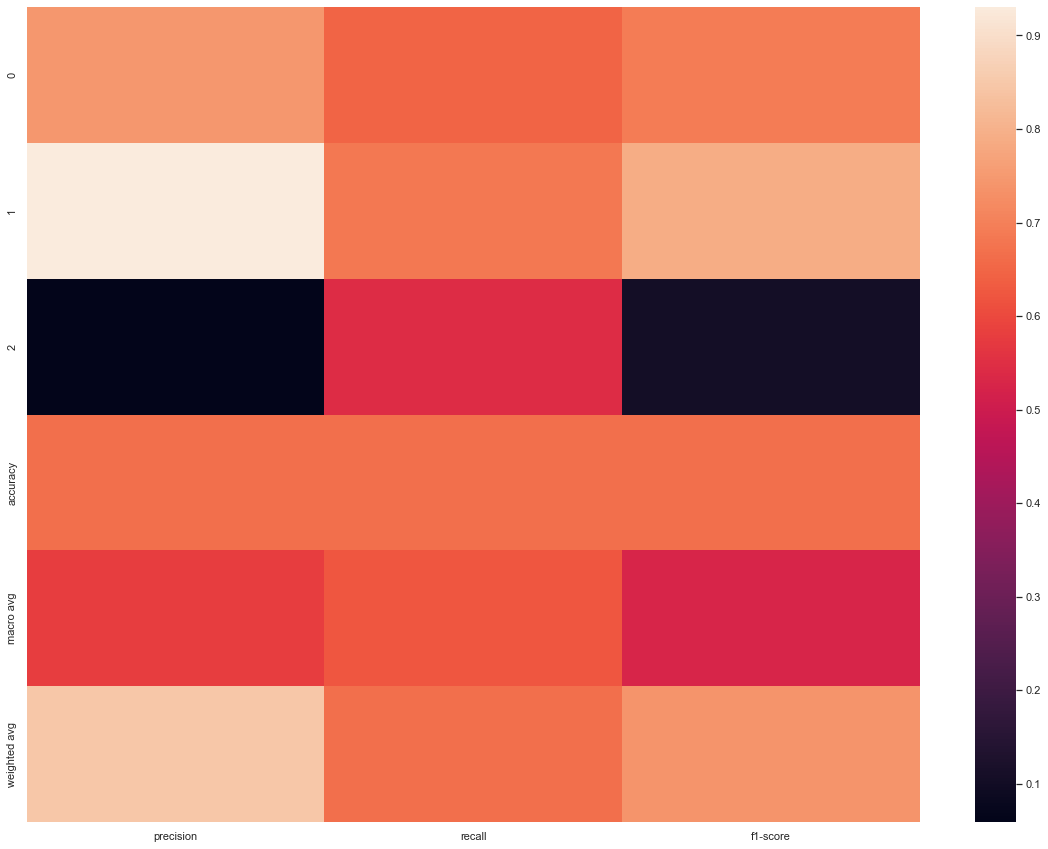

In [254]:
sns.heatmap(report_df)

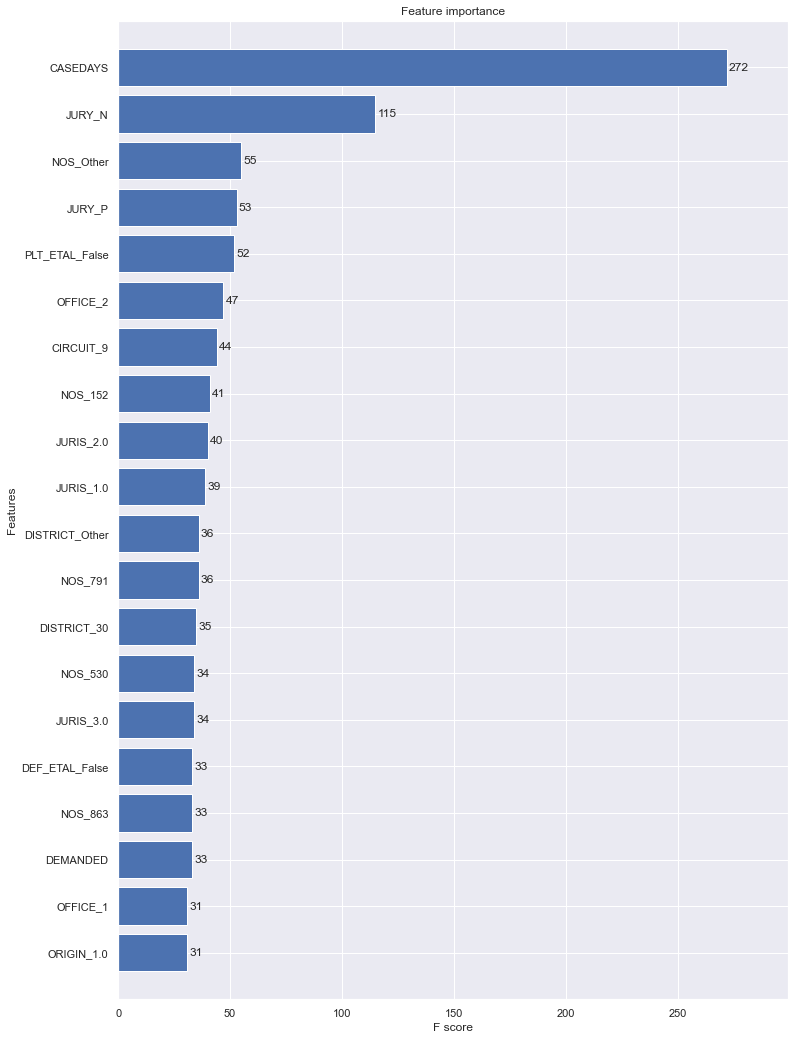

In [255]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [334]:
X_df = df_ohe.loc[:,df_ohe.columns != 'LABEL']
y_df = df_ohe['LABEL']

X_train , X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2,shuffle=True)

In [248]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [339]:
avg_val = 50000
strategy = {2:avg_val, 3:avg_val, 4:avg_val, 5:avg_val, 6:avg_val, 8:avg_val, 9:avg_val, 10:avg_val, 11:avg_val, 12:avg_val, 13:avg_val, 14:avg_val, 15:avg_val, 16:avg_val, 17:avg_val, 18:avg_val, 19:avg_val, 20:avg_val}
oversample = SMOTE(sampling_strategy=strategy)

{2: 50000, 3: 50000, 4: 50000, 5: 50000, 6: 50000, 8: 50000, 9: 50000, 10: 50000, 11: 50000, 12: 50000, 13: 50000, 14: 50000, 15: 50000, 16: 50000, 17: 50000, 18: 50000, 19: 50000, 20: 50000}


In [342]:
X_train_smote, y_train_smote = oversample.fit_resample(X_train,y_train)

In [359]:
X_train_smote.tail()

,DEMANDED,AMTREC,TAPEYEAR,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,...,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
1618755,0.000000,0.0,2018,0.038209,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,1
1618756,0.000306,0.0,2015,0.066229,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,1
1618757,0.000000,0.0,2008,0.047149,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
1618758,0.000000,0.0,2012,0.007938,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
1618759,0.411222,0.0,2015,0.023737,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1


In [187]:
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',  
    'num_class': 21,
    'eval_metric' : 'merror'
}

In [348]:
## Incrimental XGBoost training
import xgboost as xgb
batch_size = 100000
iterations = 2
model = None
for i in range(iterations):
  print("\nIteration:",i+1,"started!\n\n")
  for start in range(0, len(X_train), batch_size):
      start_time = timeit.default_timer()
      model = xgb.train(params, dtrain=xgb.DMatrix(X_train[start:start+batch_size], y_train[start:start+batch_size]), xgb_model=model)
      stop_time = timeit.default_timer()
      y_pred = model.predict(xgb.DMatrix(X_test))
      predictions = [round(value) for value in y_pred]
      accuracy = accuracy_score(y_test, predictions)
      print("Training for Batch of size:", int(start/batch_size)+1,"of",int(len(X_train)/batch_size)+1,"done. Time:",round((stop_time - start_time),1), "seconds.","Accuracy: %.2f%%" % (accuracy*100))      
print("Training Completed!")
y_pred = model.predict(xgb.DMatrix(X_test))

Iteration: 1 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 8 done. Time: 39.7 seconds. Accuracy: 81.06%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 8 done. Time: 40.2 seconds. Accuracy: 81.45%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 8 done. Time: 40.5 seconds. Accuracy: 81.69%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 8 done. Time: 41.2 seconds. Accuracy: 81.92%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 8 done. Time: 41.7 seconds. Accuracy: 82.07%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 8 done. Time: 41.8 seconds. Accuracy: 82.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 8 done. Time: 42.2 seconds. Accuracy: 82.38%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 8 done. Time: 42.2 seconds. Accuracy: 82.51%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 8 done. Time: 13.6 seconds. Accuracy: 82.58%
Iteration: 2 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 8 done. Time: 43.2 seconds. Accuracy: 82.64%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 8 done. Time: 43.1 seconds. Accuracy: 82.71%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 8 done. Time: 43.3 seconds. Accuracy: 82.81%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 8 done. Time: 43.3 seconds. Accuracy: 82.88%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 8 done. Time: 43.1 seconds. Accuracy: 82.95%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 8 done. Time: 43.1 seconds. Accuracy: 82.94%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 8 done. Time: 43.8 seconds. Accuracy: 82.99%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 8 done. Time: 44.0 seconds. Accuracy: 83.04%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 8 done. Time: 14.2 seconds. Accuracy: 82.98%
Training Completed!


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [349]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 82.98%


In [367]:
report = classification_report(y_test,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.02      0.04     27390
           1       0.86      0.00      0.01     21136
           2       0.27      0.00      0.00      9227
           3       0.09      0.02      0.04      1886
           4       0.32      0.04      0.07      5348
           5       0.09      0.01      0.02      1170
           6       0.00      0.00      0.00       976
           7       0.87      0.00      0.00    130971
           8       0.08      0.19      0.11      1020
           9       0.01      0.07      0.02       305
          10       0.00      0.00      0.00        98
          11       0.00      0.00      0.00       372
          12       0.00      0.00      0.00      2454
          13       0.00      0.00      0.00       203
          14       0.01      0.00      0.00      4423
          15       0.01      0.11      0.02       324
          16       0.00      0.00      0.00       218
          17       0.00    

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [377]:
report = classification_report(y_test,predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:,:-1]
#print(report_df)


              precision    recall  f1-score
0              0.510638  0.021030  0.040396
1              0.858696  0.003738  0.007443
2              0.270270  0.001084  0.002159
3              0.094828  0.023330  0.037447
4              0.324881  0.038332  0.068573
5              0.093567  0.013675  0.023863
6              0.000000  0.000000  0.000000
7              0.866667  0.000993  0.001983
8              0.080571  0.188235  0.112842
9              0.010338  0.072131  0.018085
10             0.000000  0.000000  0.000000
11             0.000000  0.000000  0.000000
12             0.000000  0.000000  0.000000
13             0.000000  0.000000  0.000000
14             0.008895  0.001583  0.002687
15             0.008956  0.108025  0.016541
16             0.000000  0.000000  0.000000
17             0.000889  0.388060  0.001774
18             0.000000  0.000000  0.000000
19             0.000194  0.071429  0.000387
20             0.000401  0.742424  0.000801
accuracy       0.006822  0.00682

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

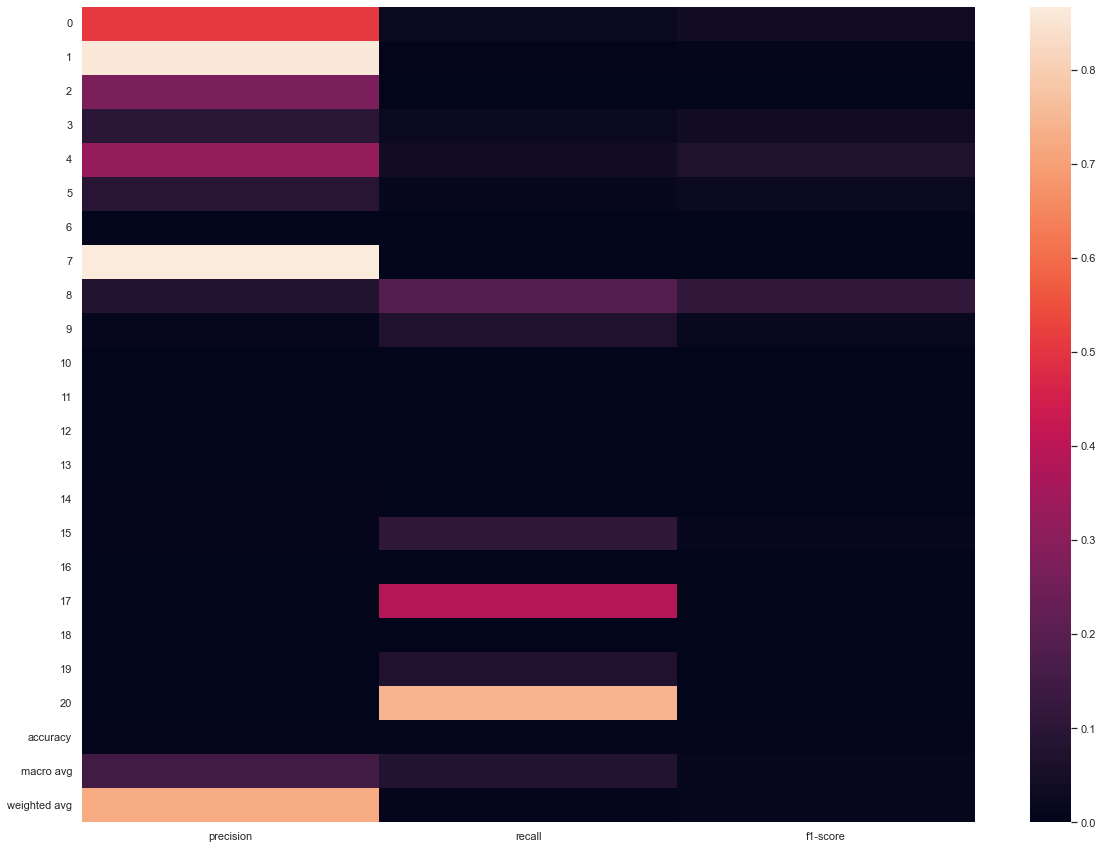

In [378]:
sns.heatmap(report_df)

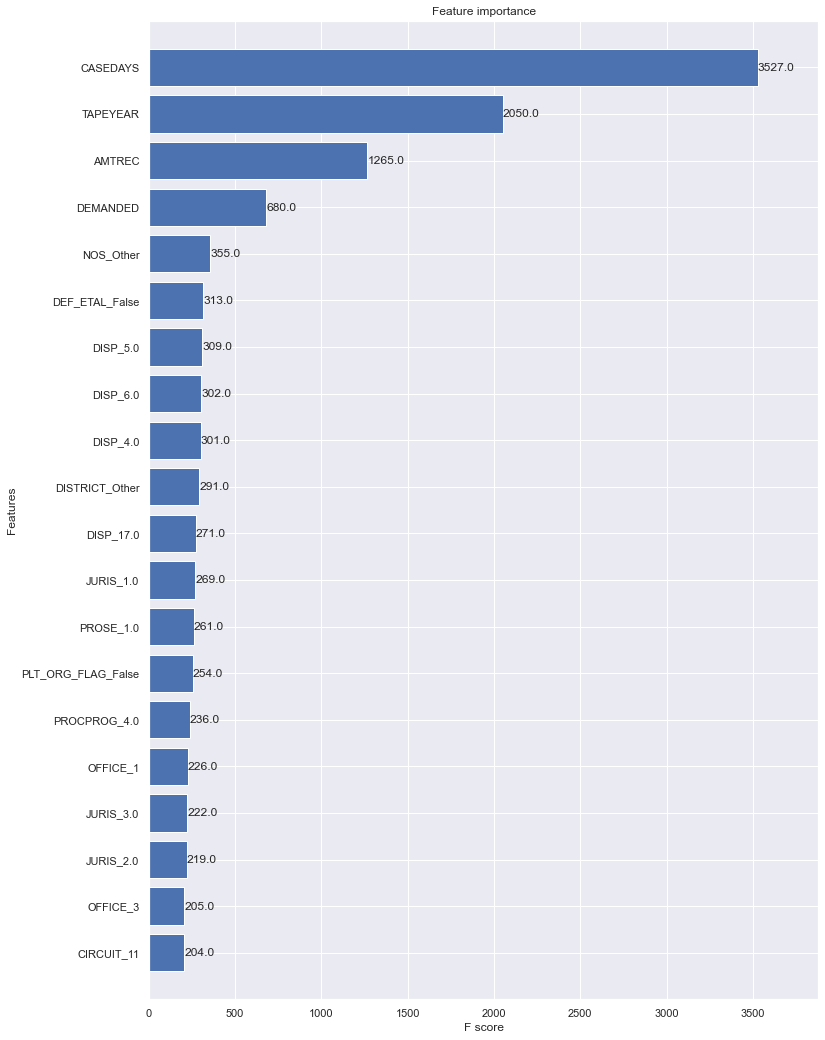

In [351]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [344]:
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',  
    'num_class': 21,
    'eval_metric' : 'merror'
}

In [353]:
## Incrimental XGBoost training
import xgboost as xgb
batch_size = 200000
iterations = 2
model = None

for i in range(iterations):
  print("\nIteration:",i+1,"started!\n\n")
  for start in range(0, len(X_train_smote), batch_size):
      start_time = timeit.default_timer()
      model = xgb.train(params, dtrain=xgb.DMatrix(X_train_smote[start:start+batch_size], y_train_smote[start:start+batch_size]), xgb_model=model)
      stop_time = timeit.default_timer()
      y_pred = model.predict(xgb.DMatrix(X_test))
      predictions = [round(value) for value in y_pred]
      accuracy = accuracy_score(y_test, predictions)
      print("Training for Batch of size:", int(start/batch_size)+1,"of",int(len(X_train_smote)/batch_size)+1,"done. Time:",round((stop_time - start_time),1), "seconds.","Accuracy: %.2f%%" % (accuracy*100))      
print("Training Completed!")
y_pred = model.predict(xgb.DMatrix(X_test))


Iteration: 1 started!


Training for Batch of size: 1 of 9 done. Time: 79.6 seconds. Accuracy: 81.09%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 9 done. Time: 81.0 seconds. Accuracy: 81.46%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 9 done. Time: 83.2 seconds. Accuracy: 81.78%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 9 done. Time: 82.9 seconds. Accuracy: 82.00%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 9 done. Time: 86.7 seconds. Accuracy: 63.17%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 9 done. Time: 46.7 seconds. Accuracy: 0.50%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 9 done. Time: 42.7 seconds. Accuracy: 21.07%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 9 done. Time: 40.0 seconds. Accuracy: 0.21%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 9 done. Time: 2.8 seconds. Accuracy: 0.21%

Iteration: 2 started!




/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 1 of 9 done. Time: 33.9 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 2 of 9 done. Time: 30.4 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 3 of 9 done. Time: 30.3 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 4 of 9 done. Time: 30.0 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 5 of 9 done. Time: 29.7 seconds. Accuracy: 0.23%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 6 of 9 done. Time: 47.5 seconds. Accuracy: 24.58%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 7 of 9 done. Time: 61.1 seconds. Accuracy: 20.54%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 8 of 9 done. Time: 53.8 seconds. Accuracy: 4.01%


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Training for Batch of size: 9 of 9 done. Time: 3.2 seconds. Accuracy: 0.68%
Training Completed!


/opt/homebrew/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [354]:
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 0.68%


In [240]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred_prob = tree.predict

In [242]:
roc_auc_score(y_test, predictions,multi_class="ovr")

AxisError: axis 1 is out of bounds for array of dimension 1

In [218]:
from dask.distributed import Client
client = Client(threads_per_worker=4)
client

/opt/homebrew/lib/python3.9/site-packages/distributed/node.py:181: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53452 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:53452/status,
Dashboard: http://127.0.0.1:53452/status,Workers: 2
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53453,Workers: 2
Dashboard: http://127.0.0.1:53452/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:53461,Total threads: 4
Dashboard: http://127.0.0.1:53463/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53457,


In [217]:
client.close()

In [219]:
df_dask = dd.from_pandas(df_ohe, chunksize=100000)
df_dask

,DEMANDED,AMTREC,TAPEYEAR,LABEL,CASEDAYS,CIRCUIT_0,CIRCUIT_1,CIRCUIT_2,CIRCUIT_3,CIRCUIT_4,CIRCUIT_5,CIRCUIT_6,CIRCUIT_7,CIRCUIT_8,CIRCUIT_9,CIRCUIT_10,CIRCUIT_11,DISTRICT_1,DISTRICT_6,DISTRICT_7,DISTRICT_8,DISTRICT_9,DISTRICT_12,DISTRICT_13,DISTRICT_15,DISTRICT_16,DISTRICT_17,DISTRICT_18,DISTRICT_20,DISTRICT_22,DISTRICT_30,DISTRICT_31,DISTRICT_32,DISTRICT_33,DISTRICT_35,DISTRICT_39,DISTRICT_41,DISTRICT_42,DISTRICT_43,DISTRICT_45,DISTRICT_47,DISTRICT_52,DISTRICT_55,DISTRICT_60,DISTRICT_64,DISTRICT_70,DISTRICT_71,DISTRICT_72,DISTRICT_73,DISTRICT_74,DISTRICT_79,DISTRICT_81,DISTRICT_82,DISTRICT_Other,OFFICE_0,OFFICE_1,OFFICE_2,OFFICE_3,OFFICE_4,OFFICE_5,OFFICE_6,OFFICE_7,OFFICE_8,OFFICE_9,ORIGIN_1.0,ORIGIN_2.0,ORIGIN_3.0,ORIGIN_4.0,ORIGIN_5.0,ORIGIN_6.0,ORIGIN_7.0,ORIGIN_8.0,ORIGIN_9.0,ORIGIN_10.0,ORIGIN_11.0,ORIGIN_12.0,ORIGIN_13.0,JURIS_1.0,JURIS_2.0,JURIS_3.0,JURIS_4.0,JURIS_5.0,NOS_110,NOS_152,NOS_190,NOS_220,NOS_360,NOS_365,NOS_367,NOS_440,NOS_442,NOS_510,NOS_530,NOS_550,NOS_555,NOS_625,NOS_710,NOS_791,NOS_820,NOS_840,NOS_850,NOS_863,NOS_864,NOS_890,NOS_Other,JURY_B,JURY_D,JURY_N,JURY_Other,JURY_P,PROCPROG_1.0,PROCPROG_2.0,PROCPROG_3.0,PROCPROG_4.0,PROCPROG_5.0,PROCPROG_6.0,PROCPROG_7.0,PROCPROG_8.0,PROCPROG_9.0,PROCPROG_10.0,PROCPROG_11.0,PROCPROG_12.0,PROCPROG_13.0,DISP_1.0,DISP_2.0,DISP_3.0,DISP_4.0,DISP_5.0,DISP_6.0,DISP_7.0,DISP_8.0,DISP_9.0,DISP_11.0,DISP_12.0,DISP_13.0,DISP_14.0,DISP_15.0,DISP_16.0,DISP_17.0,DISP_18.0,DISP_19.0,DISP_20.0,PROSE_0.0,PROSE_1.0,PROSE_2.0,PROSE_3.0,STATUSCD_L,PLT_ETAL_False,PLT_ETAL_True,DEF_ETAL_False,DEF_ETAL_True,PLT_ORG_FLAG_False,PLT_ORG_FLAG_True,DEF_ORG_FLAG_False,DEF_ORG_FLAG_True
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float32,float32,int16,int8,float32,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8,int8
100000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000000,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [220]:
X_dfdd = df_dask.loc[:,df_dask.columns != 'LABEL']
y_dfdd = df_dask['LABEL']

In [221]:
X_ddtrain, X_ddtest = X_dfdd.random_split([0.9, 0.1], 
                                         random_state=1234)
y_ddtrain, y_ddtest = y_dfdd.random_split([0.9, 0.1], 
                                                    random_state=1234)

In [222]:
dtrain = xgb.dask.DaskDMatrix(client, X_ddtrain, y_ddtrain)

In [225]:
start = time.time()
bst = dask_xgboost.train(client, params, X_ddtrain, y_ddtrain)
end = time.time()
print(end-start)

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/lib/python3.9/site-packages/dask_xgboost/tracker.py", line 365, in join
    while self.thread.isAlive():
AttributeError: 'Thread' object has no attribute 'isAlive'
/opt/homebrew/lib/python3.9/site-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packag

XGBoostError: [03:10:08] /private/var/folders/qz/s_n3qtjs3vzgtt_wv0_k5hyc0000gn/T/pip-install-7cvka3nb/xgboost_82495ce8a4034d4ba30792fe8ae27643/build/temp.macosx-12-arm64-3.9/xgboost/src/learner.cc:959: Check failed: header == serialisation_header_: 

  If you are loading a serialized model (like pickle in Python) generated by older
  XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version.  There's a simple script for helping
  the process. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for reference to the script, and more details about differences between saving model and
  serializing.


Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000147912468 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x00000001479a6cd4 xgboost::LearnerIO::Load(dmlc::Stream*) + 956
  [bt] (2) 3   libxgboost.dylib                    0x000000014790d4fc XGBoosterUnserializeFromBuffer + 128
  [bt] (3) 4   libffi.dylib                        0x00000001d0f90050 ffi_call_SYSV + 80
  [bt] (4) 5   libffi.dylib                        0x00000001d0f989e4 ffi_call_int + 948
  [bt] (5) 6   _ctypes.cpython-39-darwin.so        0x0000000101bc0eb8 _ctypes_callproc + 864
  [bt] (6) 7   _ctypes.cpython-39-darwin.so        0x0000000101bbb934 PyCFuncPtr_call + 220
  [bt] (7) 8   Python                              0x0000000101596a2c _PyObject_MakeTpCall + 132
  [bt] (8) 9   Python                              0x000000010168f554 call_function + 268



In [227]:
predictions = dask_xgboost.predict(client, bst, X_ddtest).persist()
predictions.head()

NameError: name 'bst' is not defined